# Imports


In [1]:
import torch
from typing import List, Callable, Union, Any, TypeVar, Tuple
from torch import nn
from torch.nn import functional as F
from torch import nn
from abc import abstractmethod
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import copy
import imageio

# Required Classes and Functions

In [2]:
Tensor = TypeVar('torch.tensor')

class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [3]:

class VectorQuantizer(nn.Module):

    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 beta: float = 0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)

    def forward(self, latents: Tensor) -> Tensor:
        latents = latents.permute(0, 2, 3, 1).contiguous()  # [B x D x H x W] -> [B x H x W x D]
        latents_shape = latents.shape
        flat_latents = latents.view(-1, self.D)  # [BHW x D]

        # Compute L2 distance between latents and embedding weights
        dist = torch.sum(flat_latents ** 2, dim=1, keepdim=True) + \
               torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(flat_latents, self.embedding.weight.t())  # [BHW x K]

        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [BHW, 1]

        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [BHW x K]

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [BHW, D]
        quantized_latents = quantized_latents.view(latents_shape)  # [B x H x W x D]

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())

        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents.permute(0, 3, 1, 2).contiguous(), vq_loss  # [B x D x H x W]

    def codebook(self):
        return self.embedding.weight.detach().cpu().numpy()

class ResidualLayer(nn.Module):

    def __init__(self,
                 in_channels: int,
                 out_channels: int):
        super(ResidualLayer, self).__init__()
        self.resblock = nn.Sequential(nn.Conv2d(in_channels, out_channels,
                                                kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv2d(out_channels, out_channels,
                                                kernel_size=1, bias=False))

    def forward(self, input: Tensor) -> Tensor:
        return input + self.resblock(input)



class VQVAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 embedding_dim: int,
                 num_embeddings: int,
                 hidden_dims: List = None,
                 beta: float = 0.25,
                 img_size: int = 28,
                 **kwargs) -> None:
        super(VQVAE, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.img_size = img_size
        self.beta = beta

        modules = []
        if hidden_dims is None:
            hidden_dims = [64, 128]  # Reduced hidden dimensions

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, embedding_dim,
                          kernel_size=1, stride=1),
                nn.LeakyReLU())
        )

        self.encoder = nn.Sequential(*modules)

        self.vq_layer = VectorQuantizer(num_embeddings,
                                        embedding_dim,
                                        self.beta)

        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim,
                          hidden_dims[-1],
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.LeakyReLU())
        )

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=4,
                                       stride=2,
                                       padding=1),
                    nn.LeakyReLU())
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[-1],
                                   out_channels=1,
                                   kernel_size=4,
                                   stride=2, padding=1),
                nn.Tanh()))

        self.decoder = nn.Sequential(*modules)


    def encode(self, input: Tensor) -> List[Tensor]:

        result = self.encoder(input)
        return [result]

    def decode(self, z: Tensor) -> Tensor:

        result = self.decoder(z)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        encoding = self.encode(input)[0]
        quantized_inputs, vq_loss = self.vq_layer(encoding)
        return [self.decode(quantized_inputs), input, vq_loss, self.vq_layer.codebook()]


# Loading Dataset

In [29]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training Function


##################################################


<ipython-input-31-0afc2de4662d>:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'frame_{epoch}.png'))


VQ-VAE Epoch [1/50], Loss: 0.1060018600351902


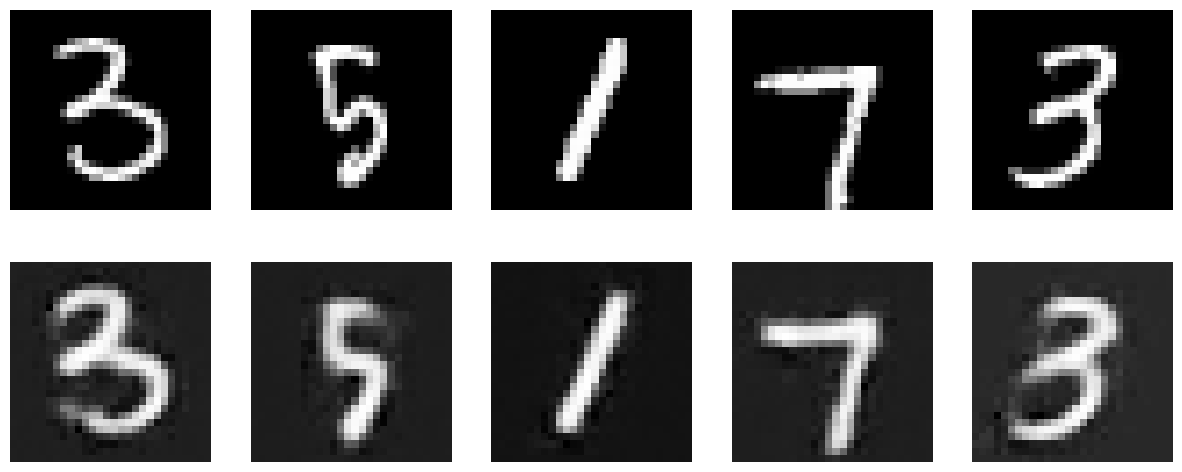


##################################################
VQ-VAE Epoch [2/50], Loss: 0.08162348322681527


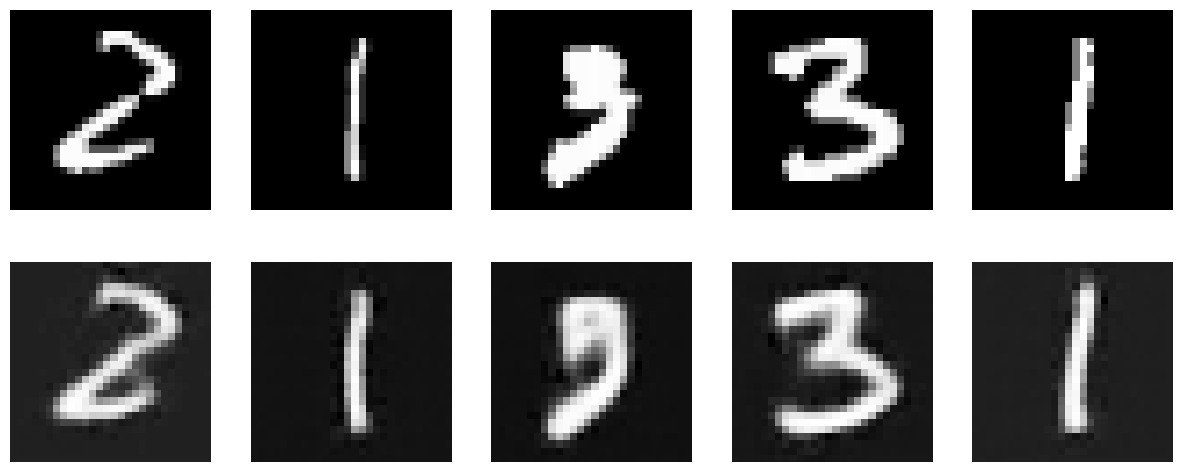


##################################################
VQ-VAE Epoch [3/50], Loss: 0.07647392403548842


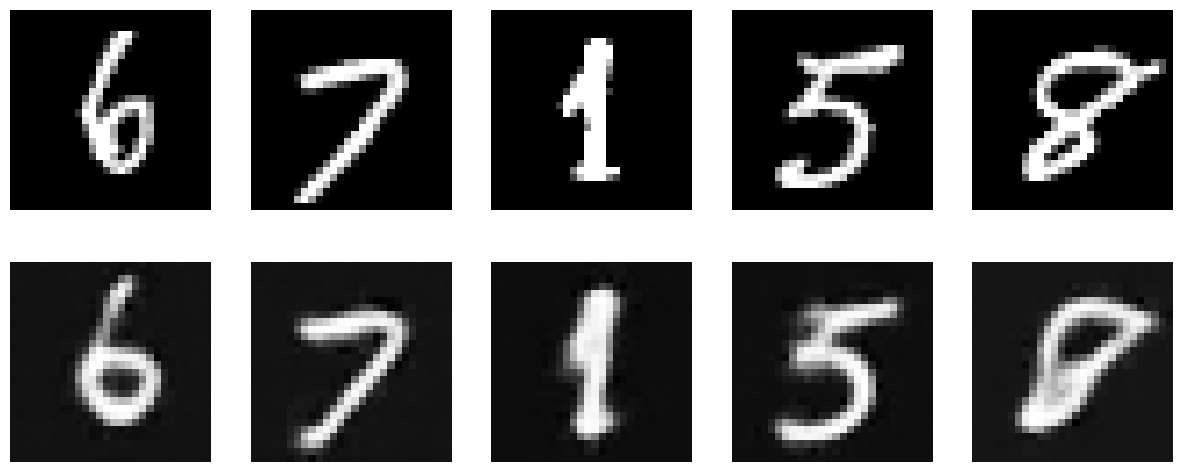


##################################################
VQ-VAE Epoch [4/50], Loss: 0.07426865963237499


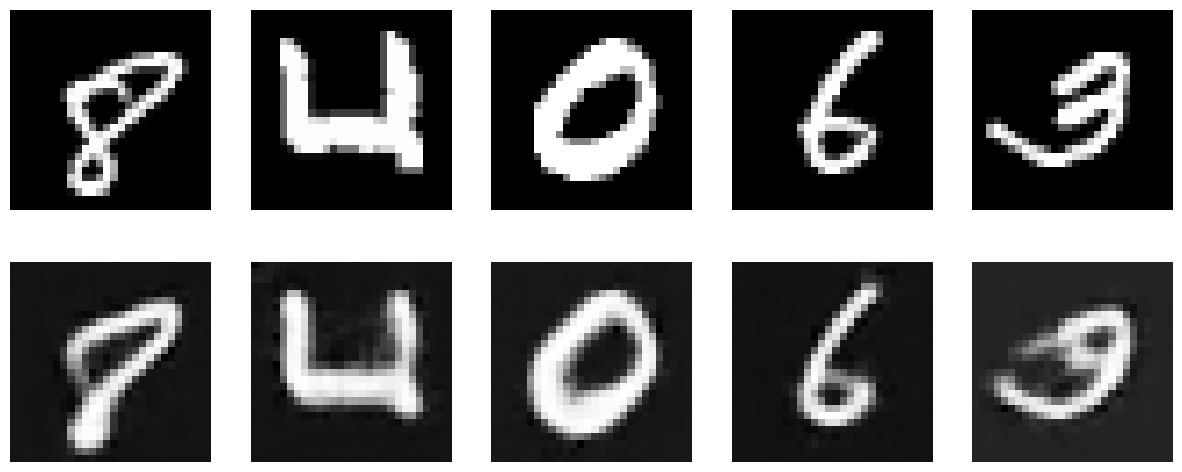


##################################################
VQ-VAE Epoch [5/50], Loss: 0.07241247403723344


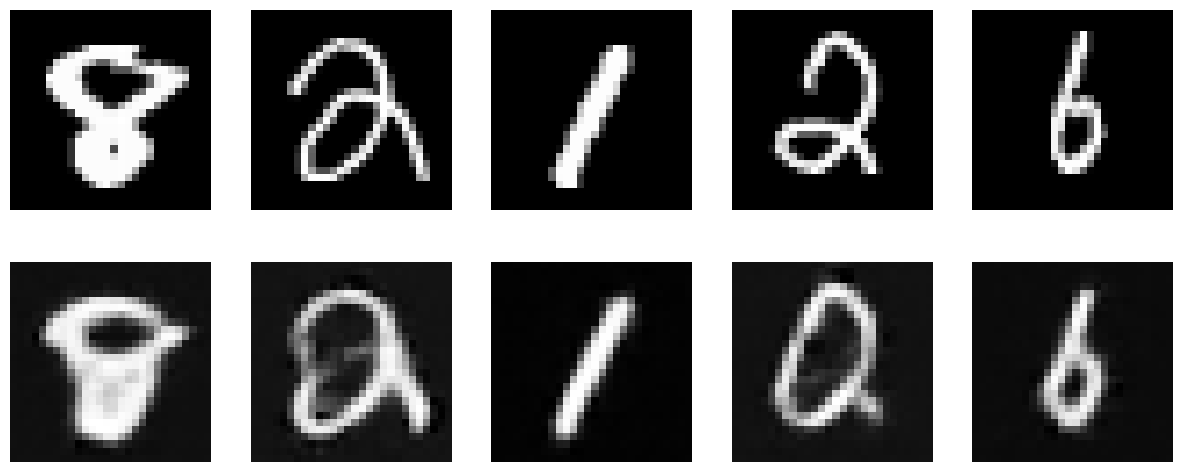


##################################################
VQ-VAE Epoch [6/50], Loss: 0.07054279281942448


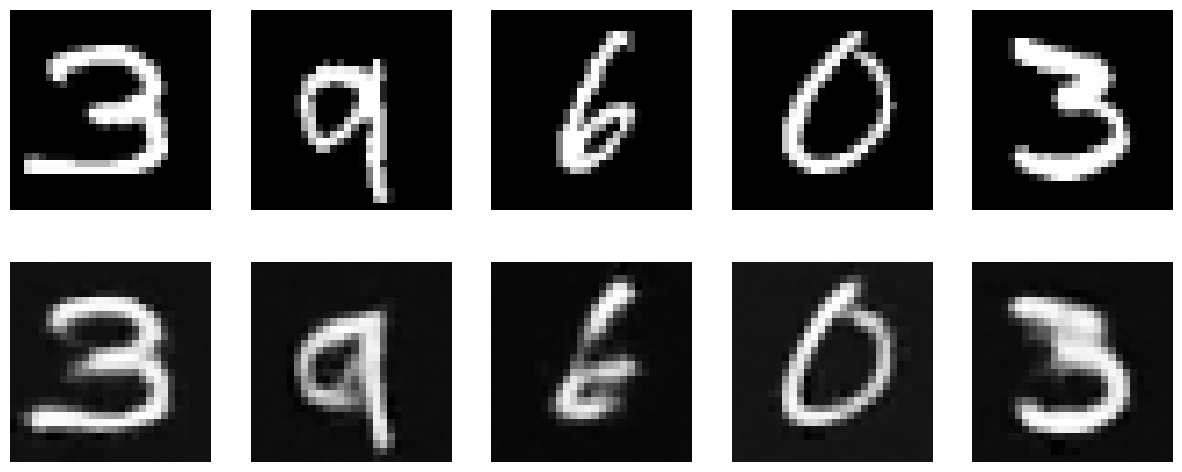


##################################################
VQ-VAE Epoch [7/50], Loss: 0.06898966822415781


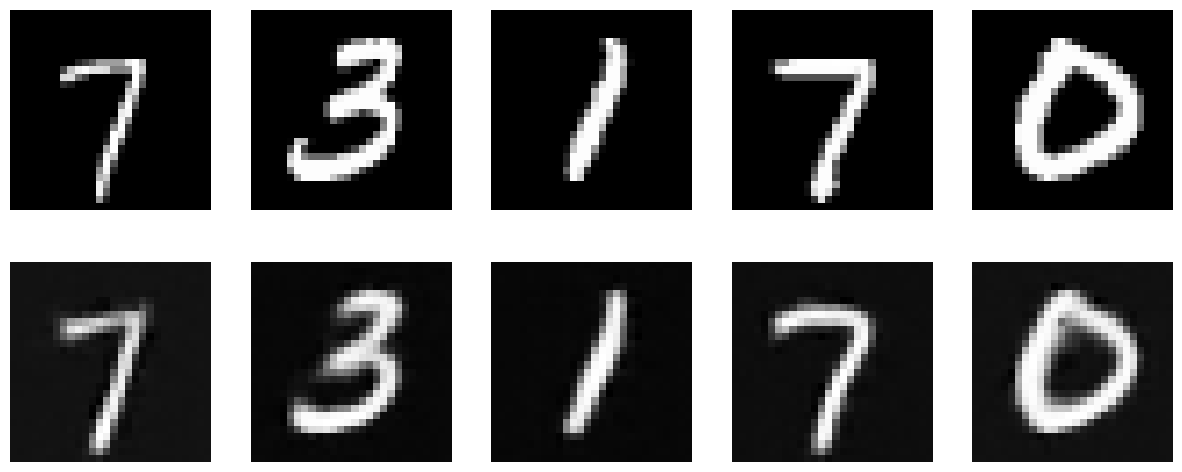


##################################################
VQ-VAE Epoch [8/50], Loss: 0.06740948670645004


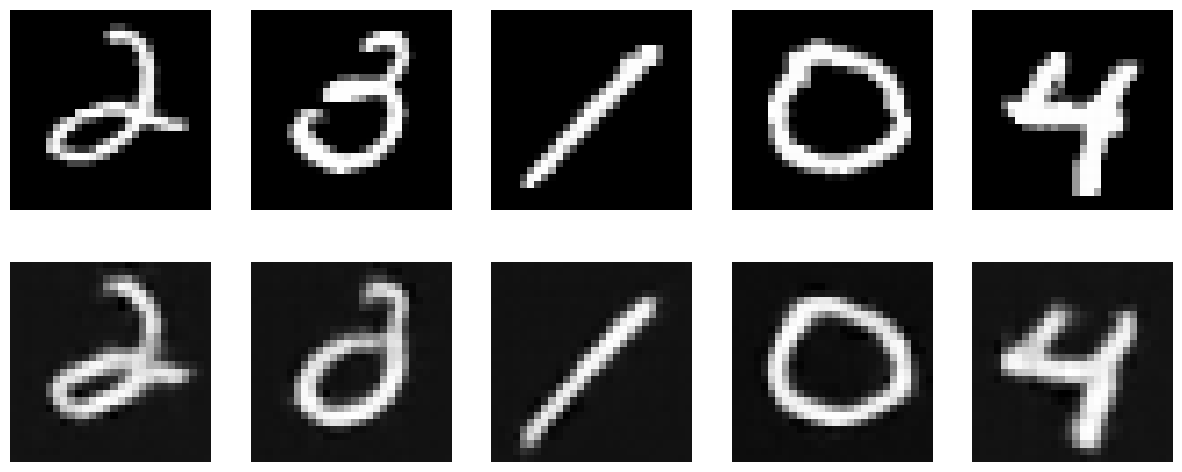


##################################################
VQ-VAE Epoch [9/50], Loss: 0.06619413001244383


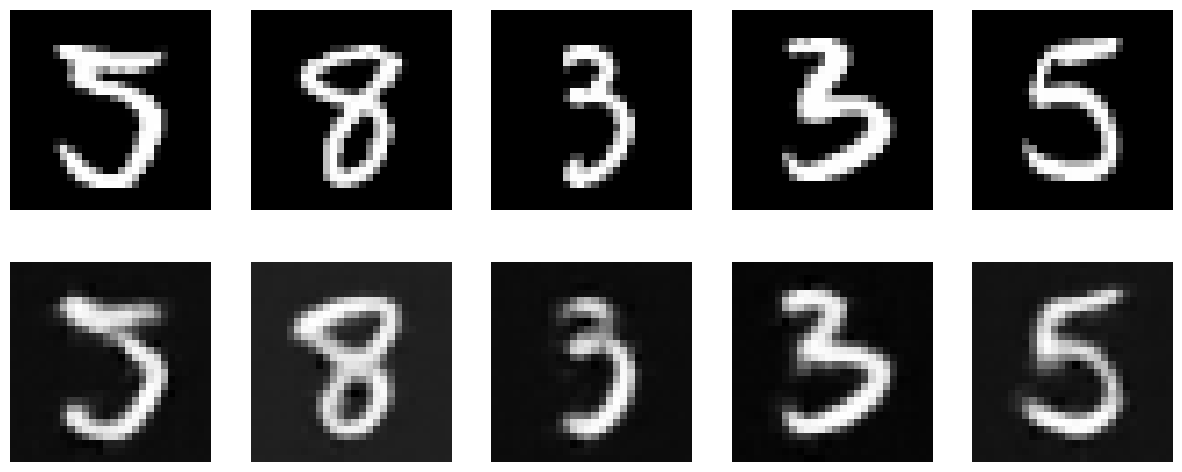


##################################################
VQ-VAE Epoch [10/50], Loss: 0.06505533399135828


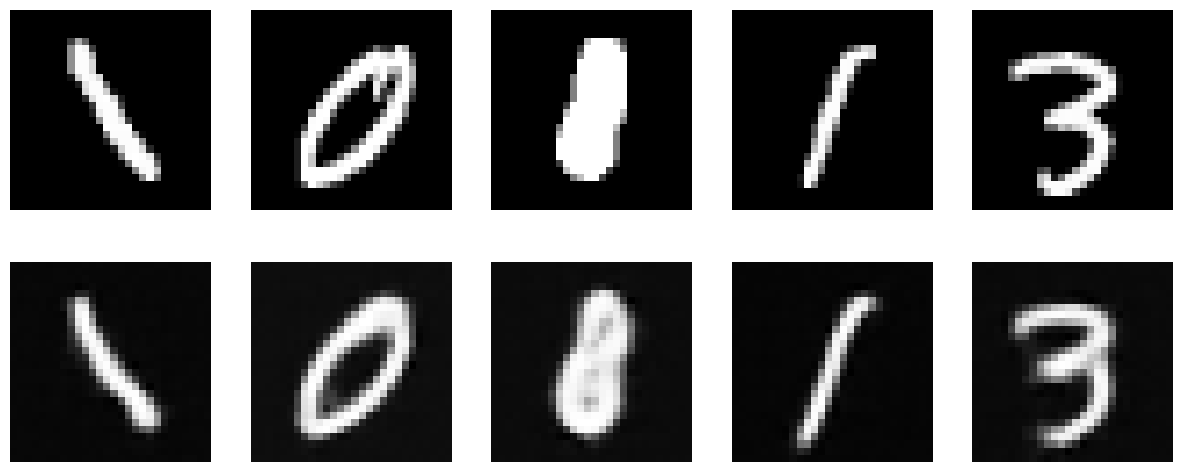


##################################################
VQ-VAE Epoch [11/50], Loss: 0.0640894073897651


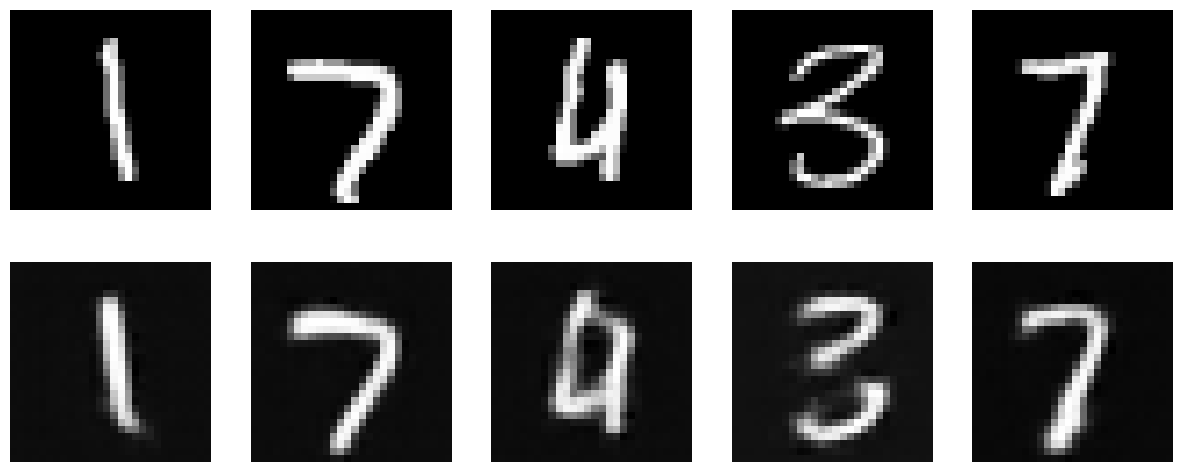


##################################################
VQ-VAE Epoch [12/50], Loss: 0.06346332476829797


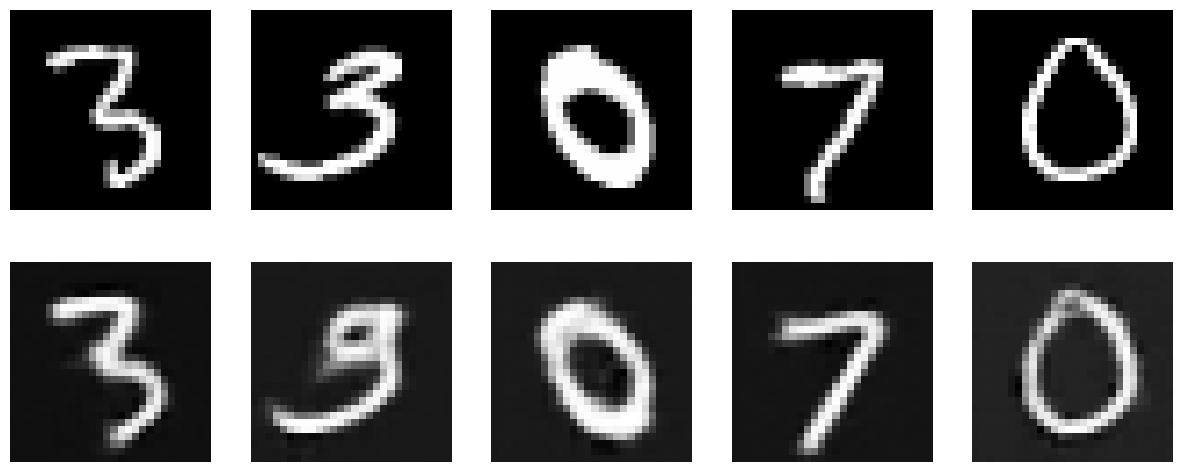


##################################################
VQ-VAE Epoch [13/50], Loss: 0.06289765571972836


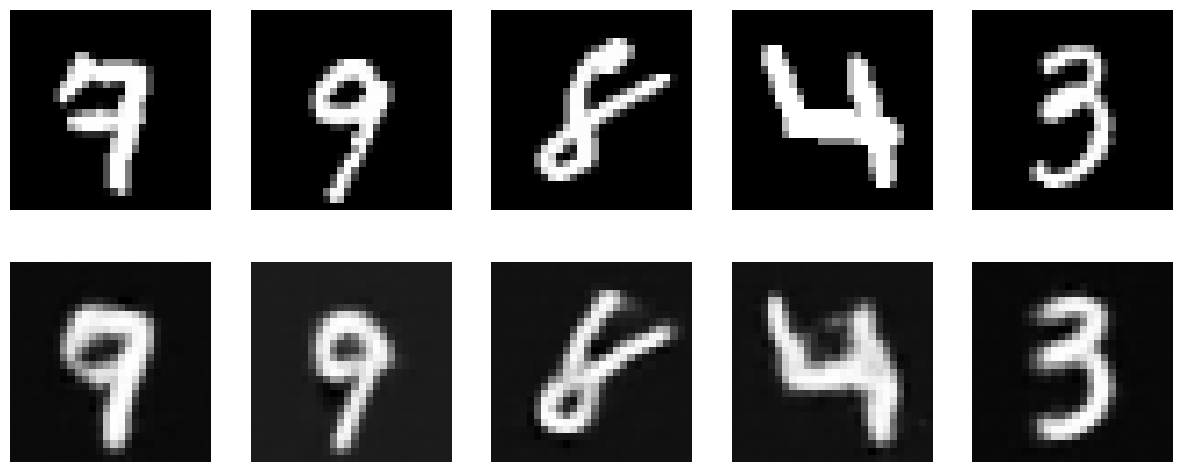


##################################################
VQ-VAE Epoch [14/50], Loss: 0.06233314294884327


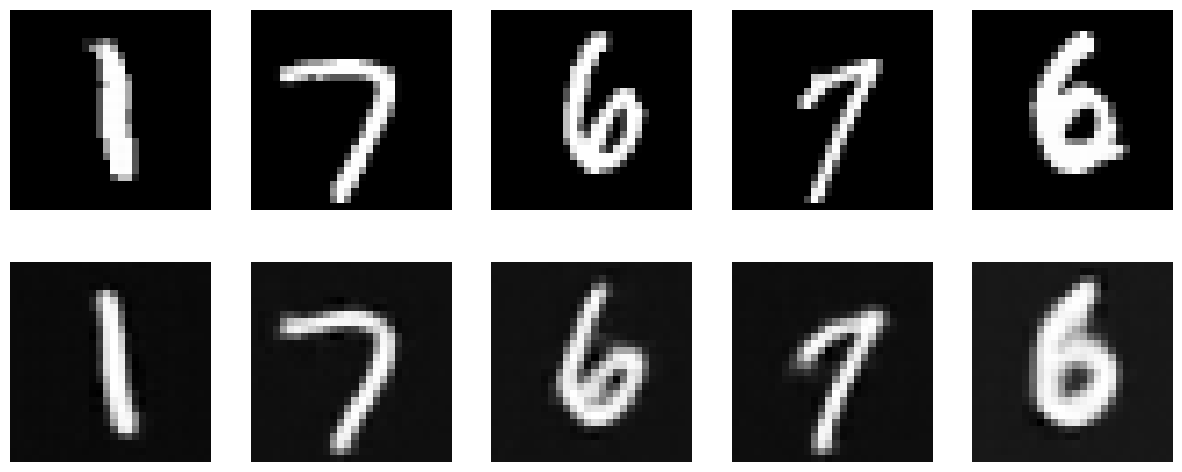


##################################################
VQ-VAE Epoch [15/50], Loss: 0.061902981644659155


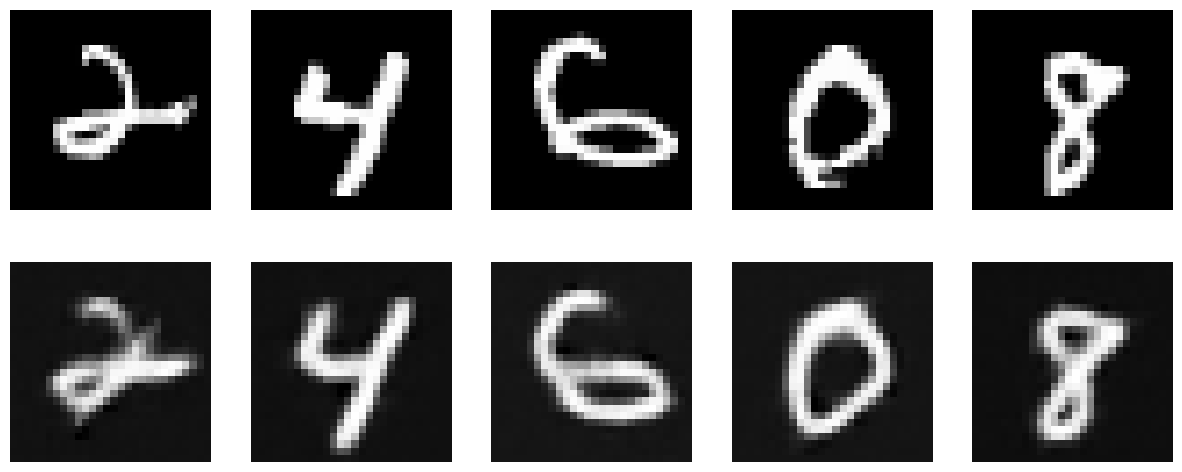


##################################################
VQ-VAE Epoch [16/50], Loss: 0.06128472090561761


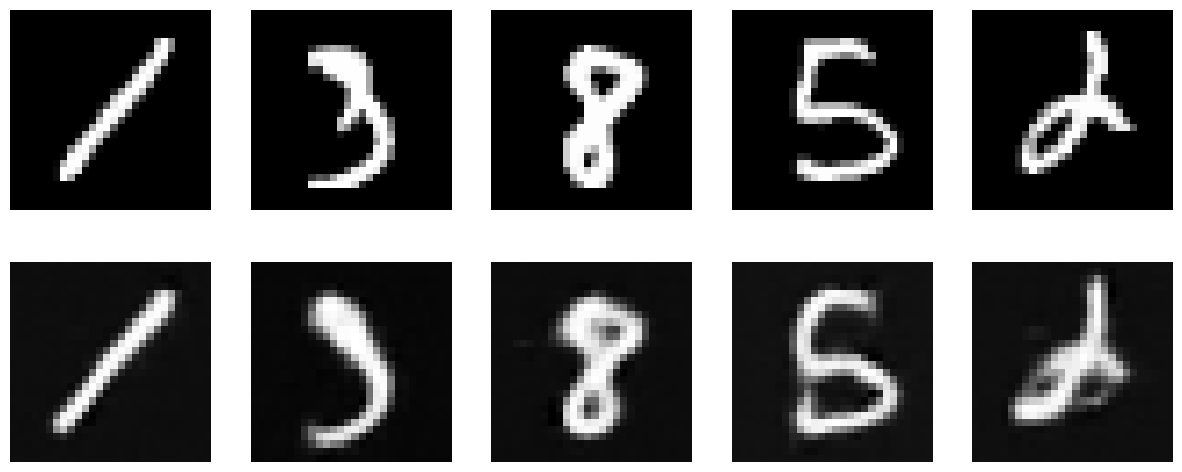


##################################################
VQ-VAE Epoch [17/50], Loss: 0.060959260700258616


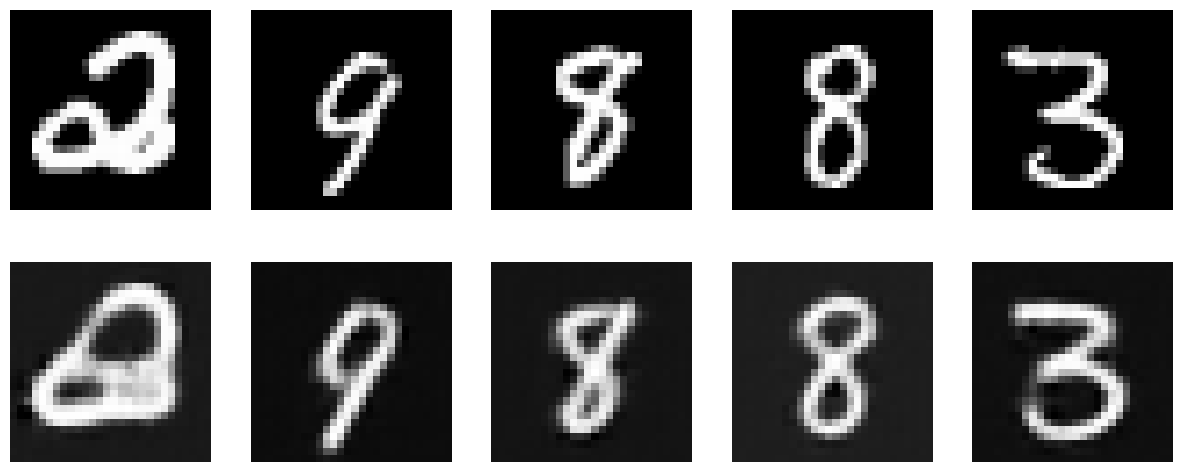


##################################################
VQ-VAE Epoch [18/50], Loss: 0.06071834861120181


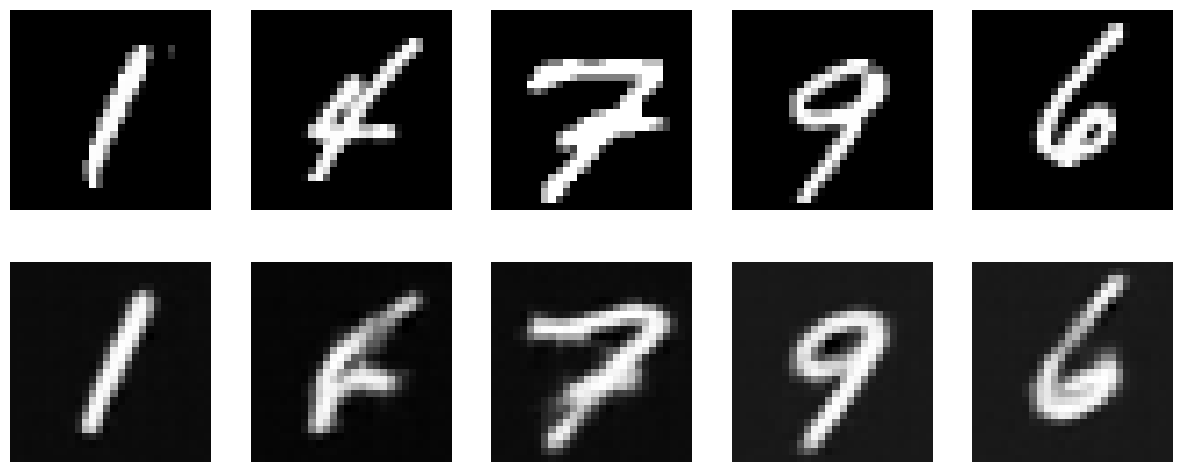


##################################################
VQ-VAE Epoch [19/50], Loss: 0.06029116201883694


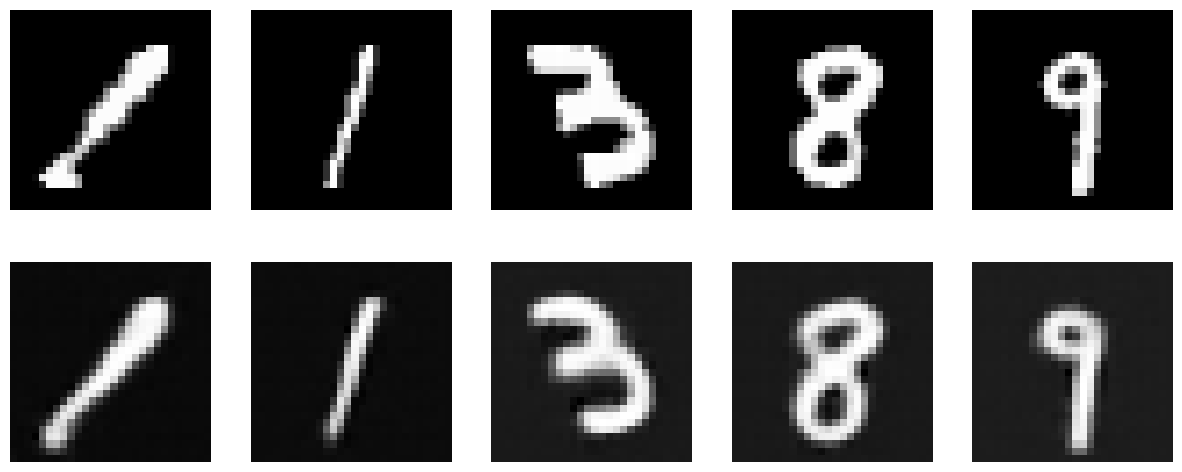


##################################################
VQ-VAE Epoch [20/50], Loss: 0.05993525086959669


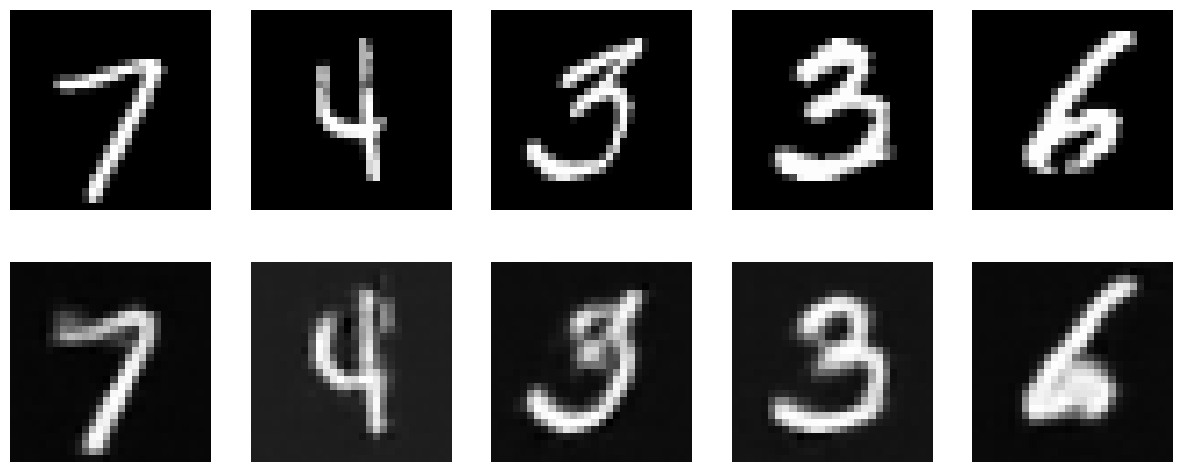


##################################################
VQ-VAE Epoch [21/50], Loss: 0.05964005812367142


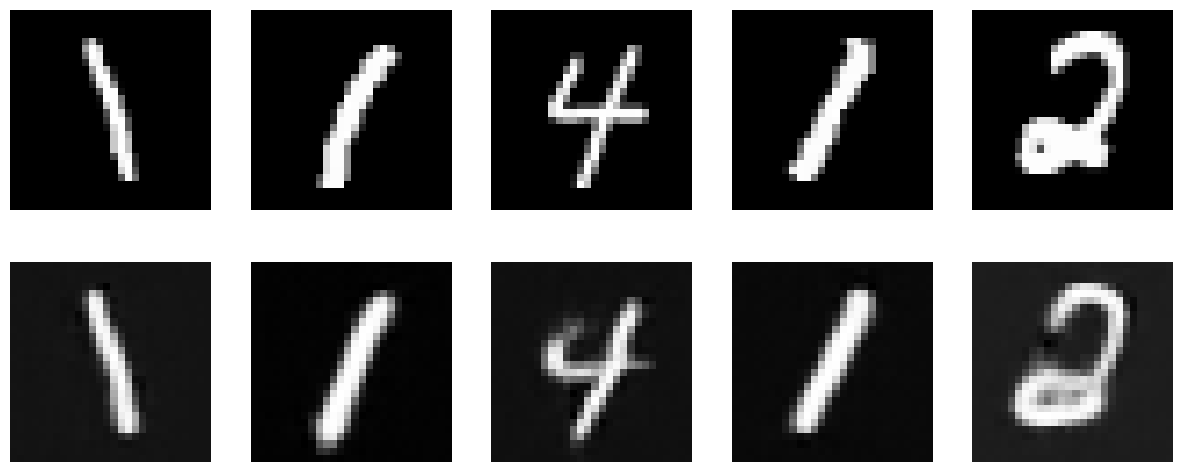


##################################################
VQ-VAE Epoch [22/50], Loss: 0.05916097635891773


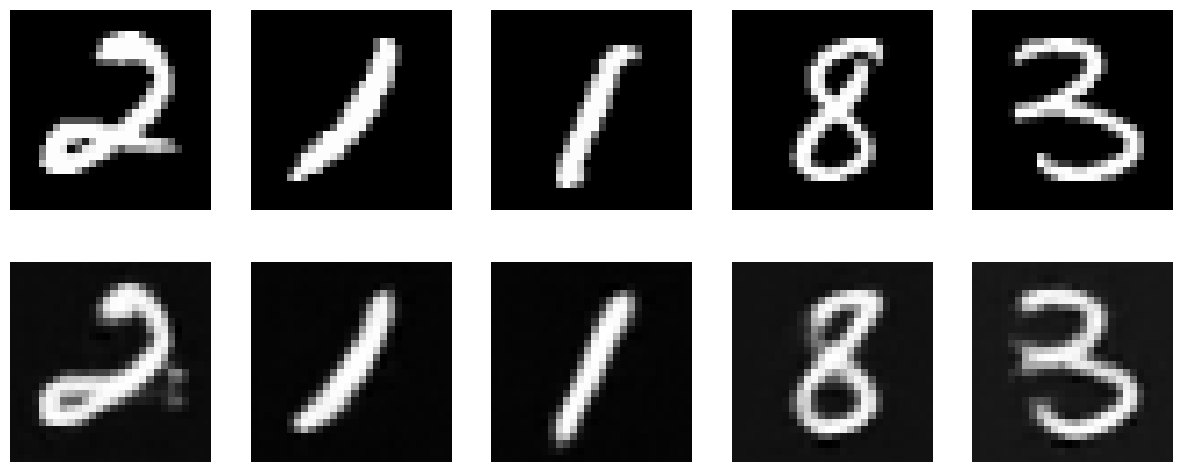


##################################################
VQ-VAE Epoch [23/50], Loss: 0.05909545974992613


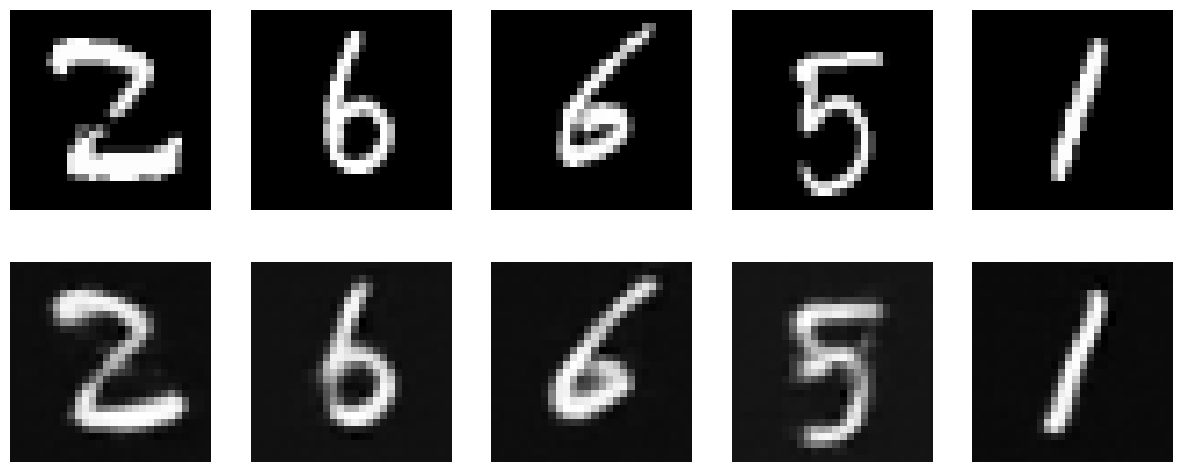


##################################################
VQ-VAE Epoch [24/50], Loss: 0.05894444419392772


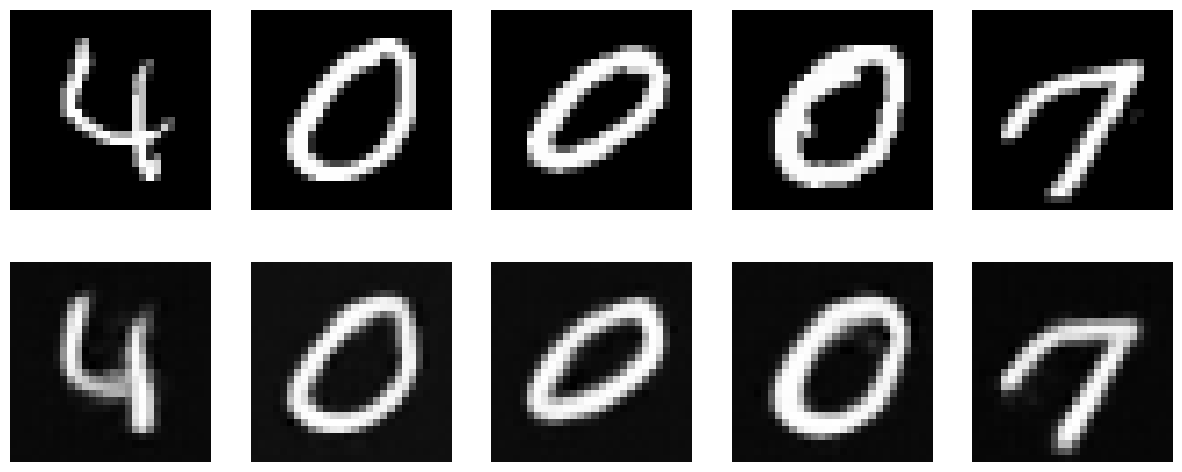


##################################################
VQ-VAE Epoch [25/50], Loss: 0.058883286436705956


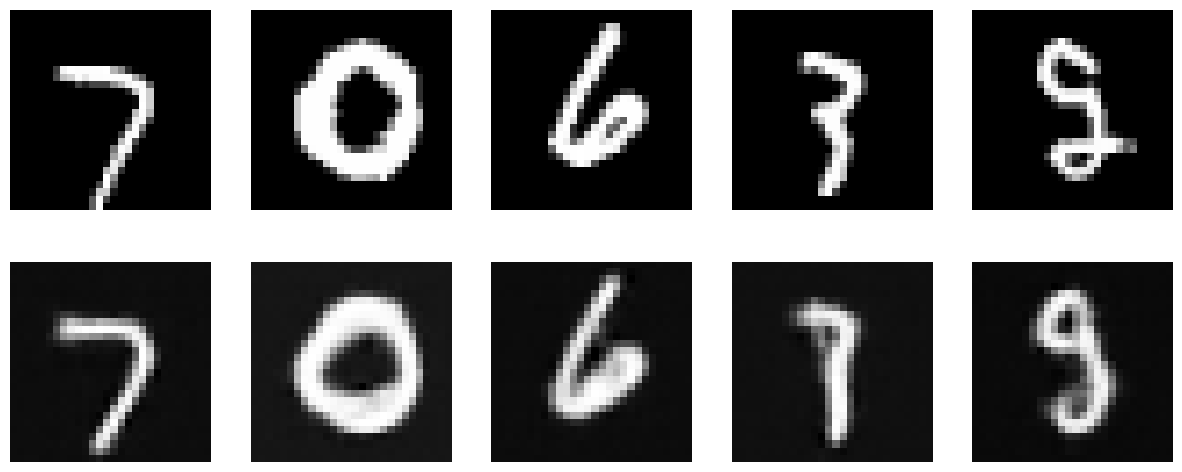


##################################################
VQ-VAE Epoch [26/50], Loss: 0.058669942691286746


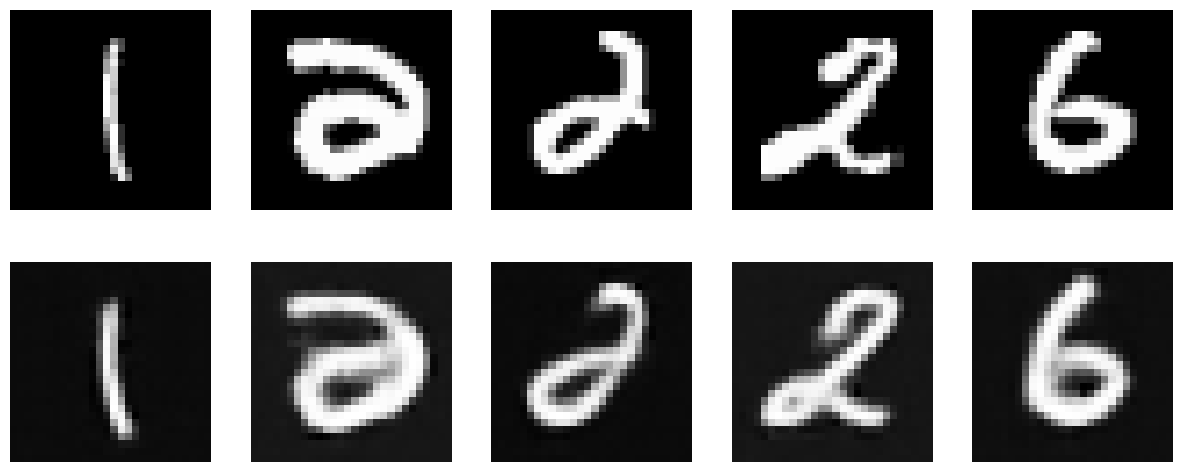


##################################################
VQ-VAE Epoch [27/50], Loss: 0.058479998626116754


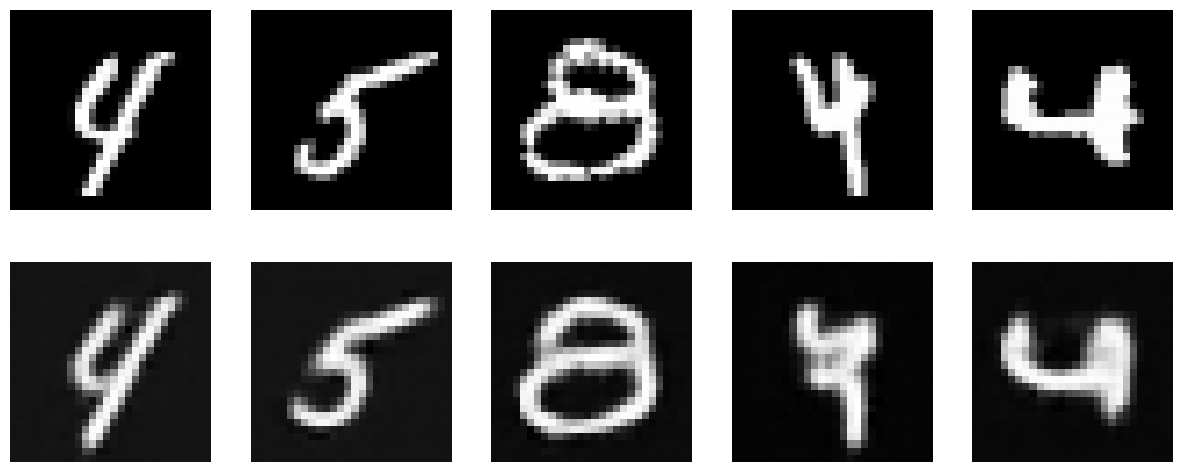


##################################################
VQ-VAE Epoch [28/50], Loss: 0.058531156723210805


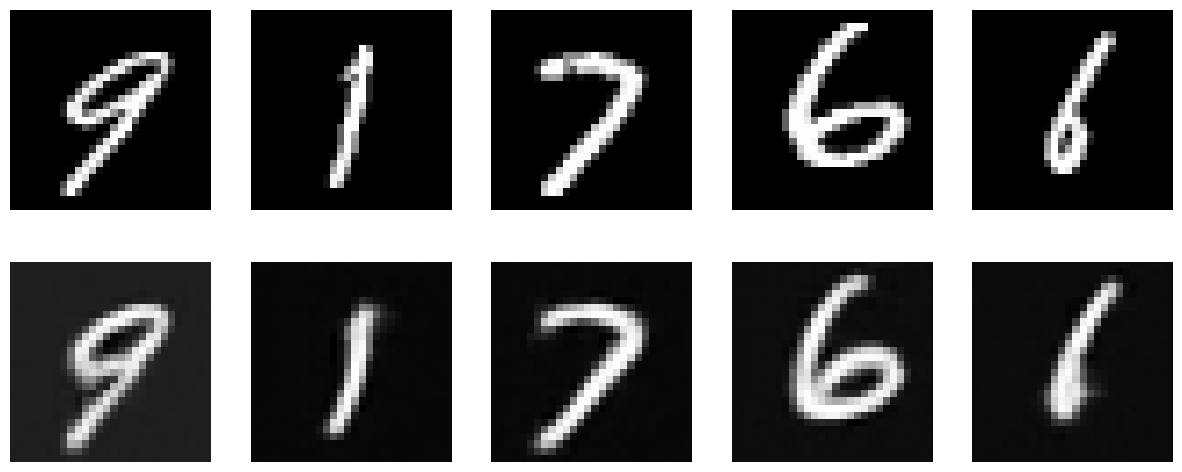


##################################################
VQ-VAE Epoch [29/50], Loss: 0.05838639339181914


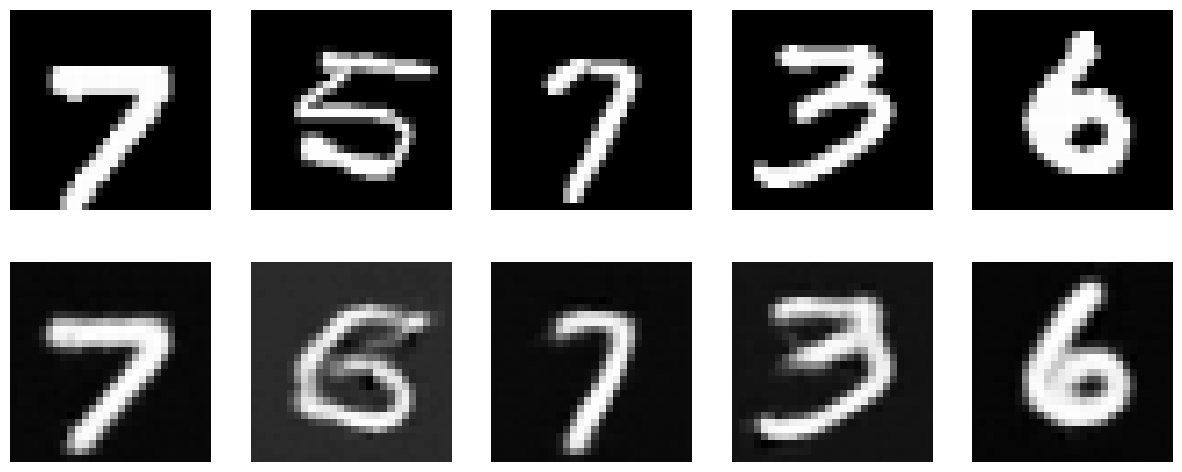


##################################################
VQ-VAE Epoch [30/50], Loss: 0.05813321170172712


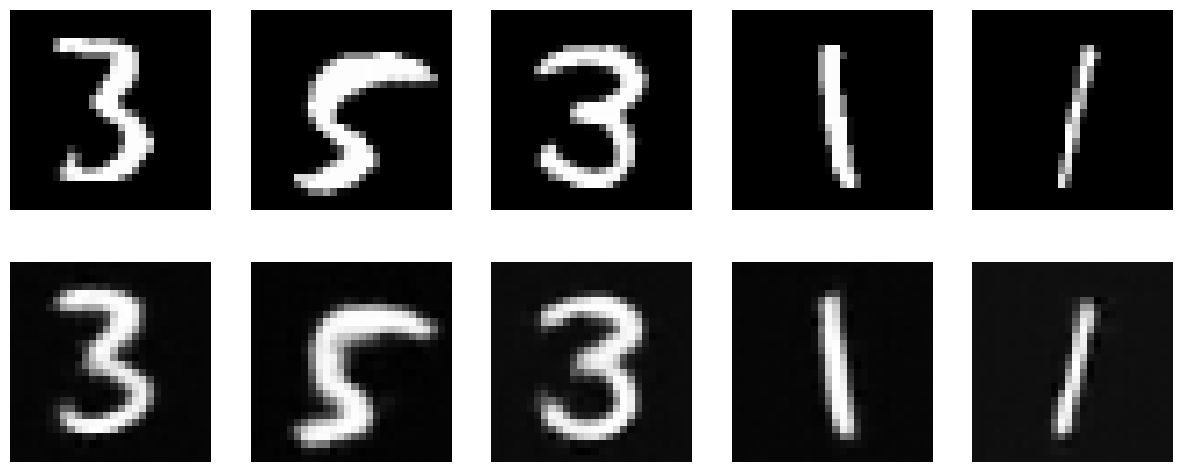


##################################################
VQ-VAE Epoch [31/50], Loss: 0.058049848942614314


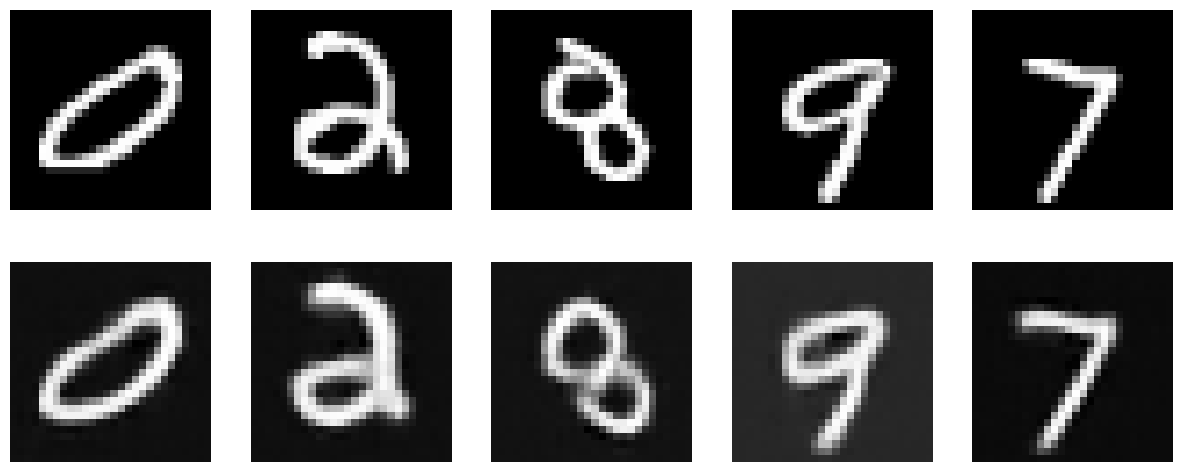


##################################################
VQ-VAE Epoch [32/50], Loss: 0.05806494443449003


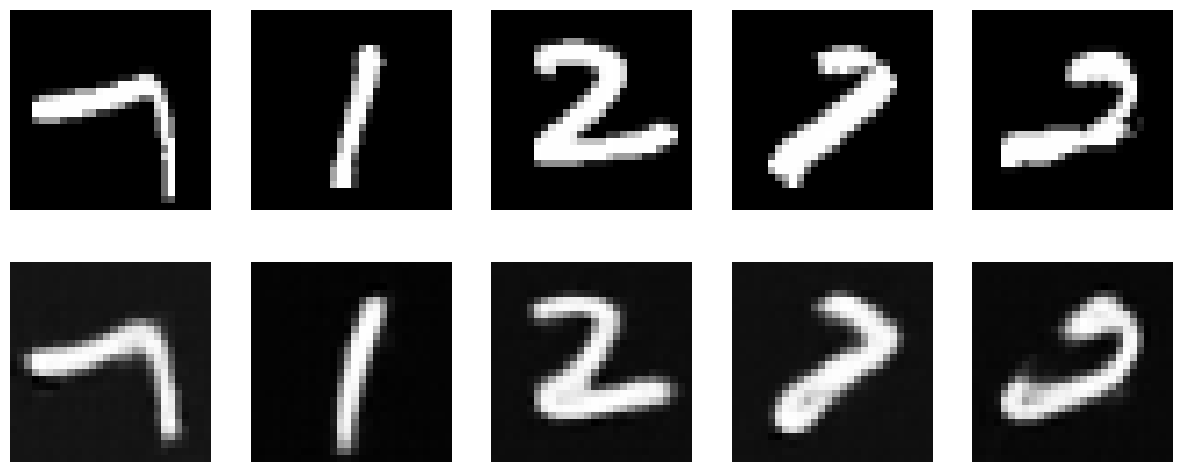


##################################################
VQ-VAE Epoch [33/50], Loss: 0.057977980272824574


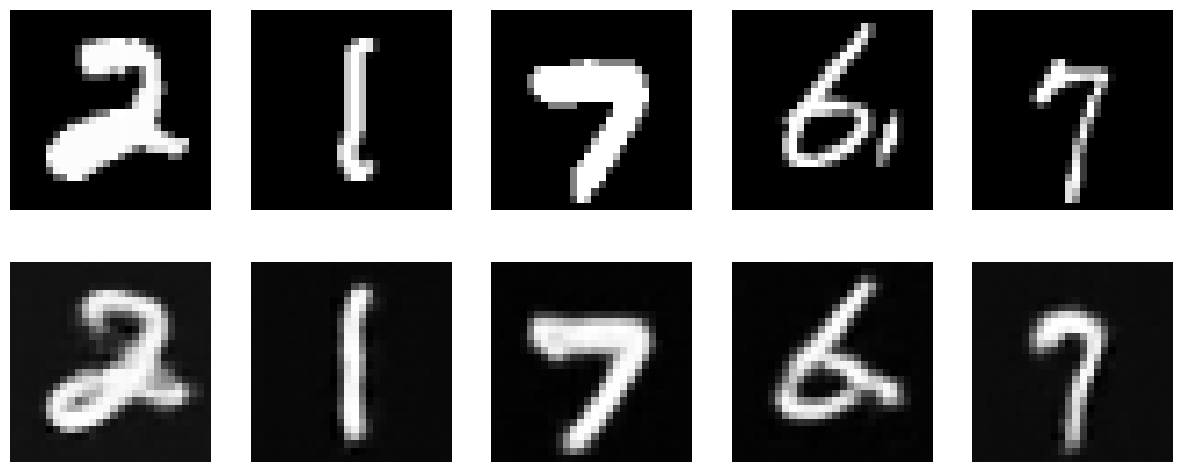


##################################################
VQ-VAE Epoch [34/50], Loss: 0.05789103105600709


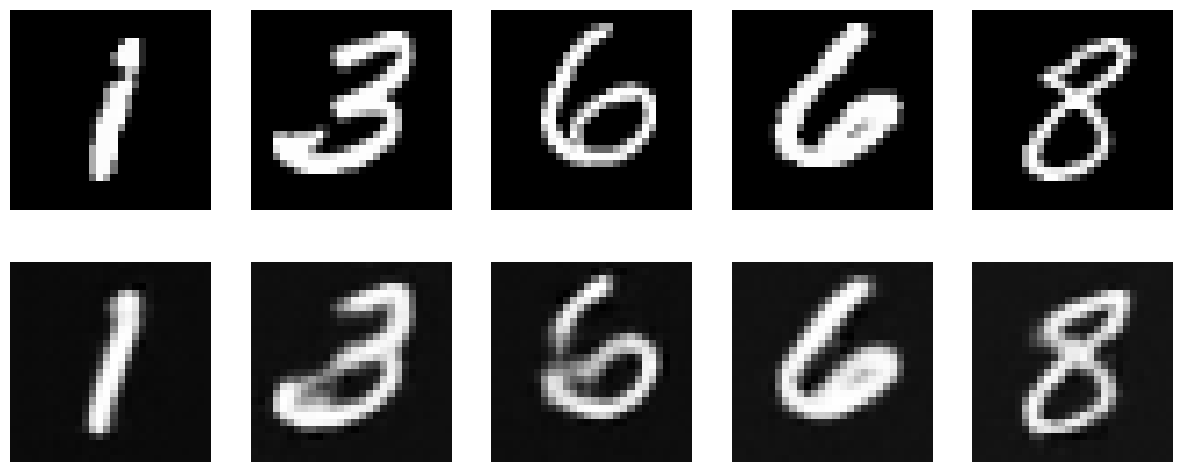


##################################################
VQ-VAE Epoch [35/50], Loss: 0.05795850556717117


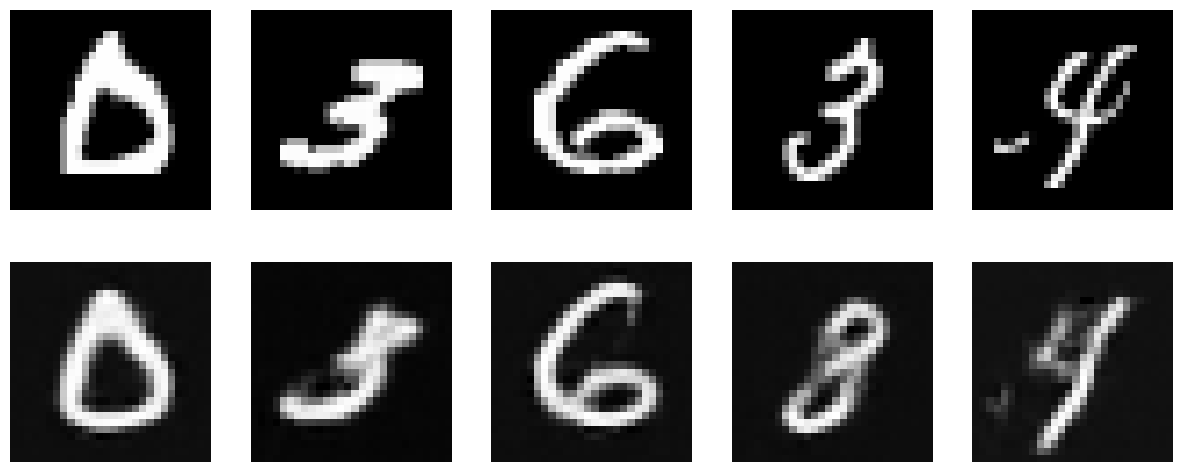


##################################################
VQ-VAE Epoch [36/50], Loss: 0.05792023997698257


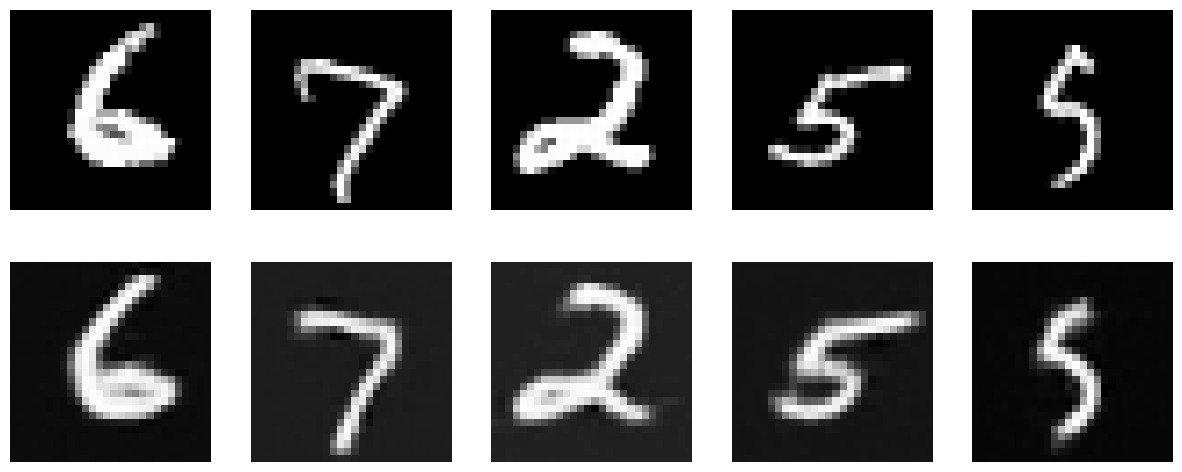


##################################################
VQ-VAE Epoch [37/50], Loss: 0.057765228626157426


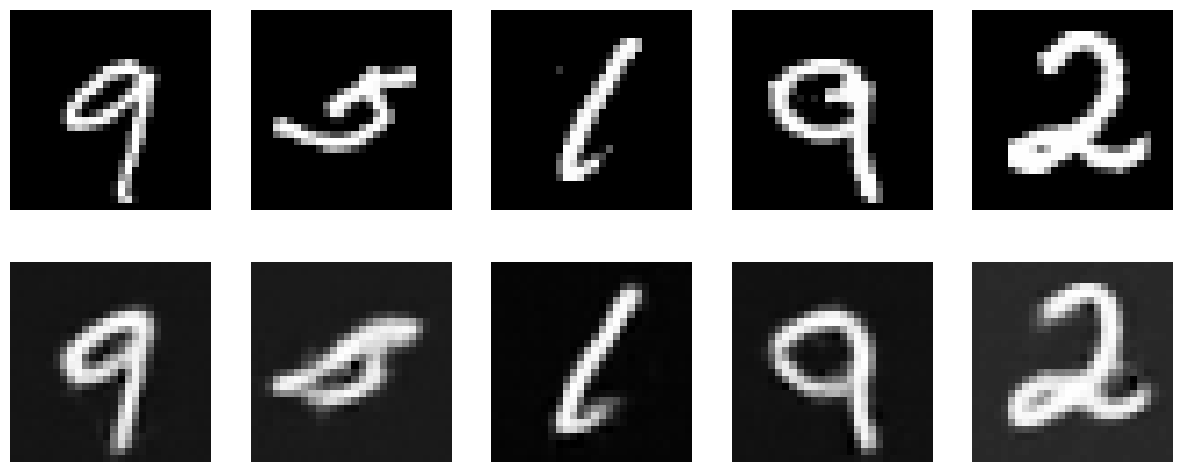


##################################################
VQ-VAE Epoch [38/50], Loss: 0.05779358028555349


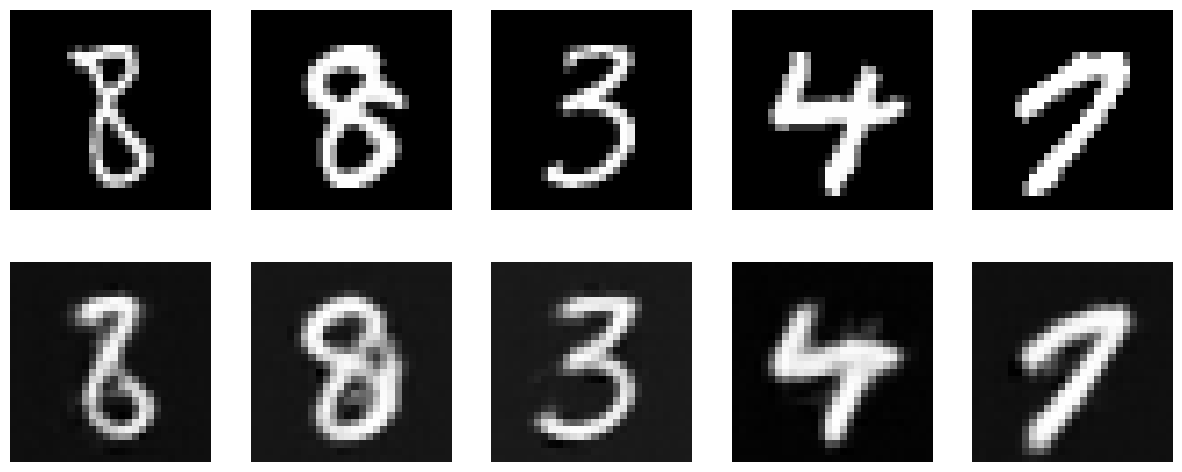


##################################################
VQ-VAE Epoch [39/50], Loss: 0.057727416735023324


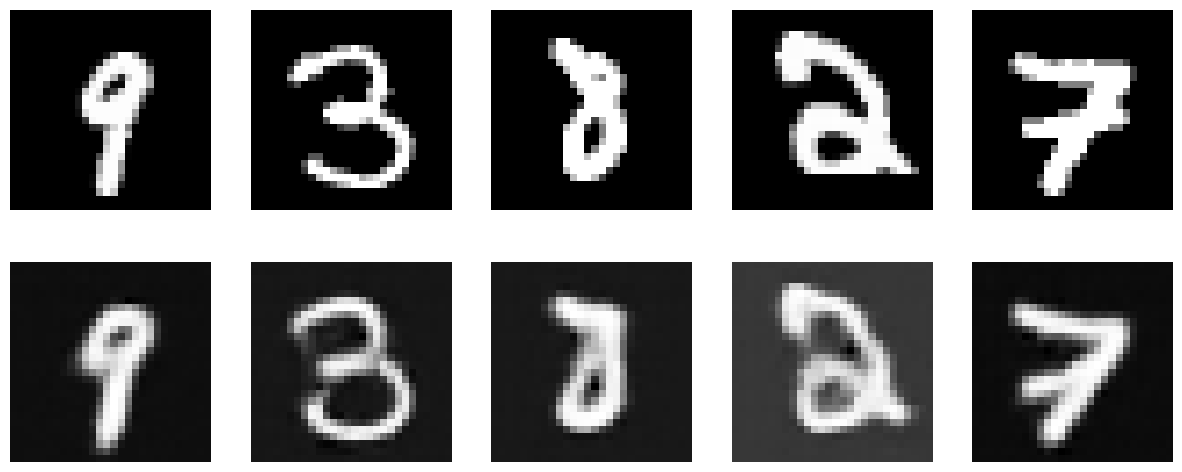


##################################################
VQ-VAE Epoch [40/50], Loss: 0.057724616972844735


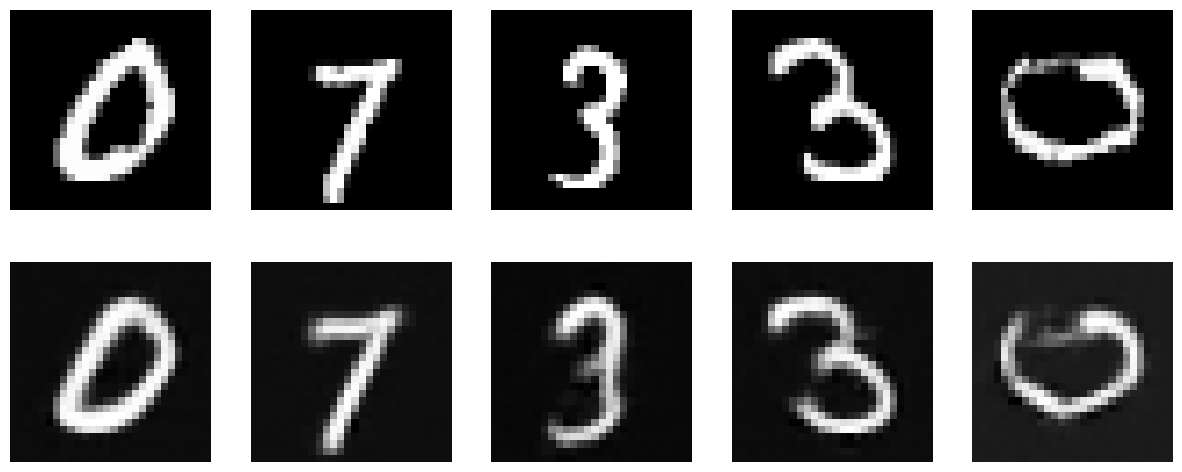


##################################################
VQ-VAE Epoch [41/50], Loss: 0.057630612830649304


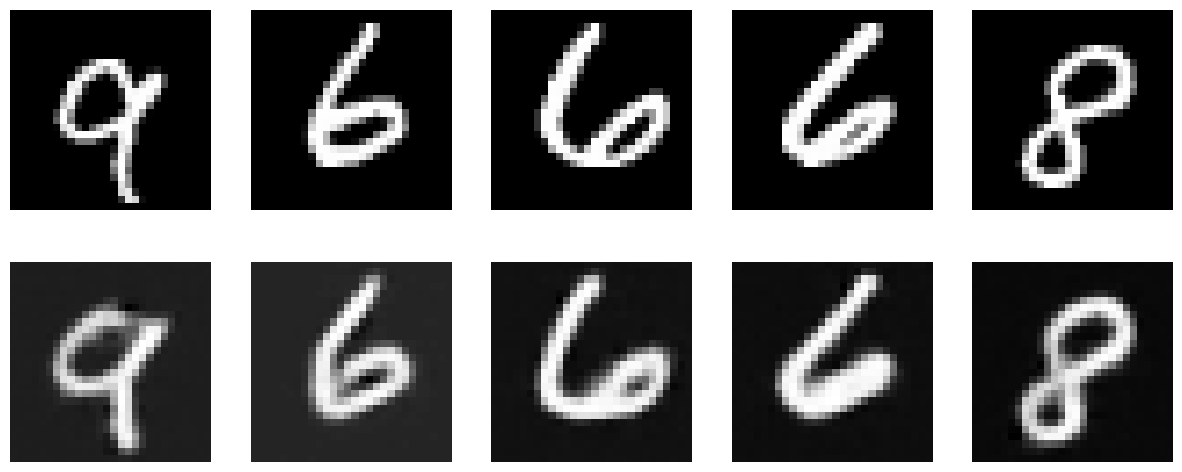


##################################################
VQ-VAE Epoch [42/50], Loss: 0.05762381379061671


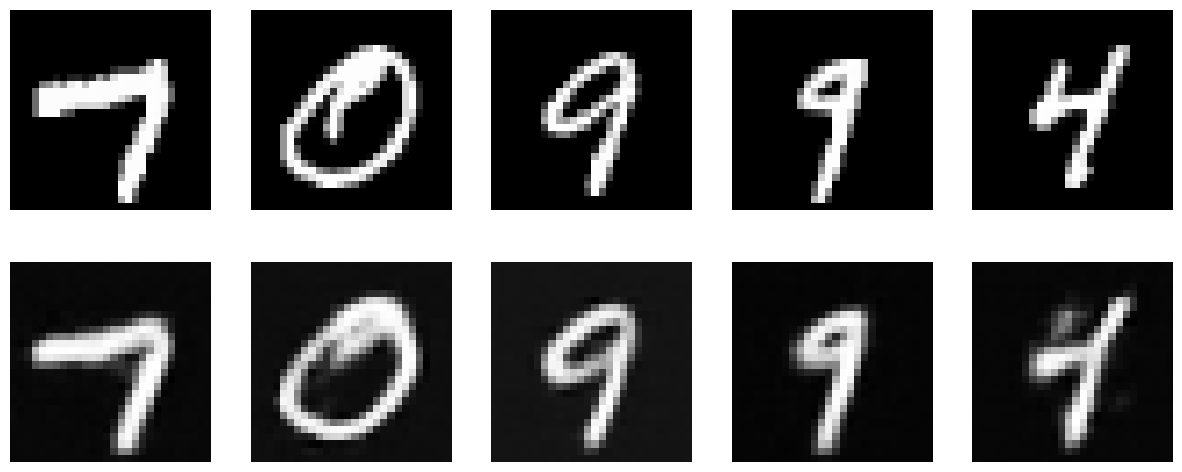


##################################################
VQ-VAE Epoch [43/50], Loss: 0.05768331033842904


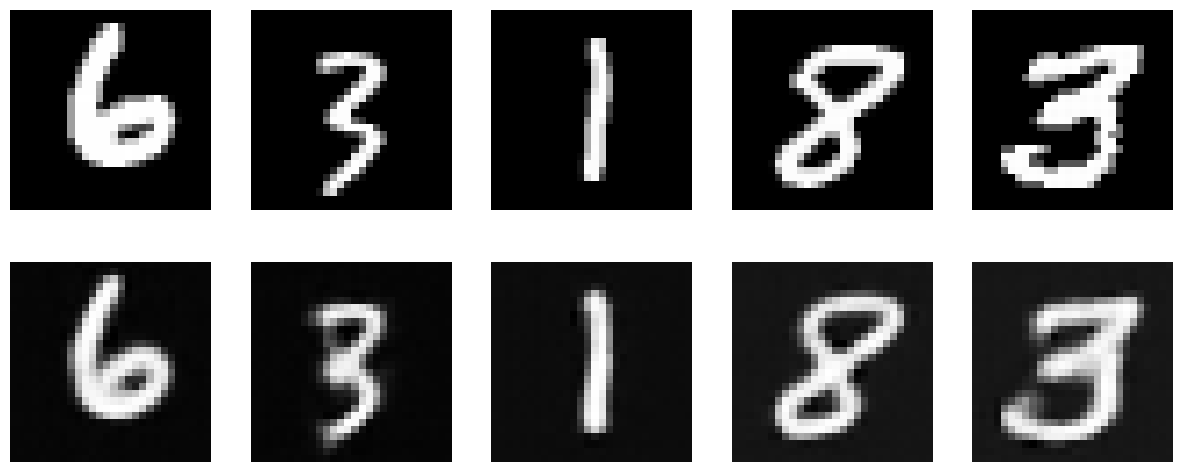


##################################################
VQ-VAE Epoch [44/50], Loss: 0.05762739516874112


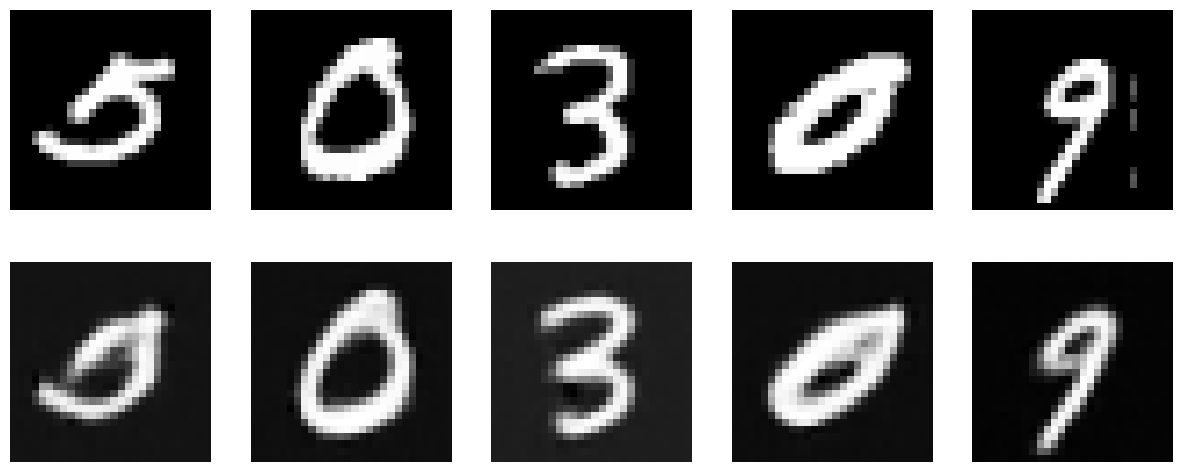


##################################################
VQ-VAE Epoch [45/50], Loss: 0.05761245565056038


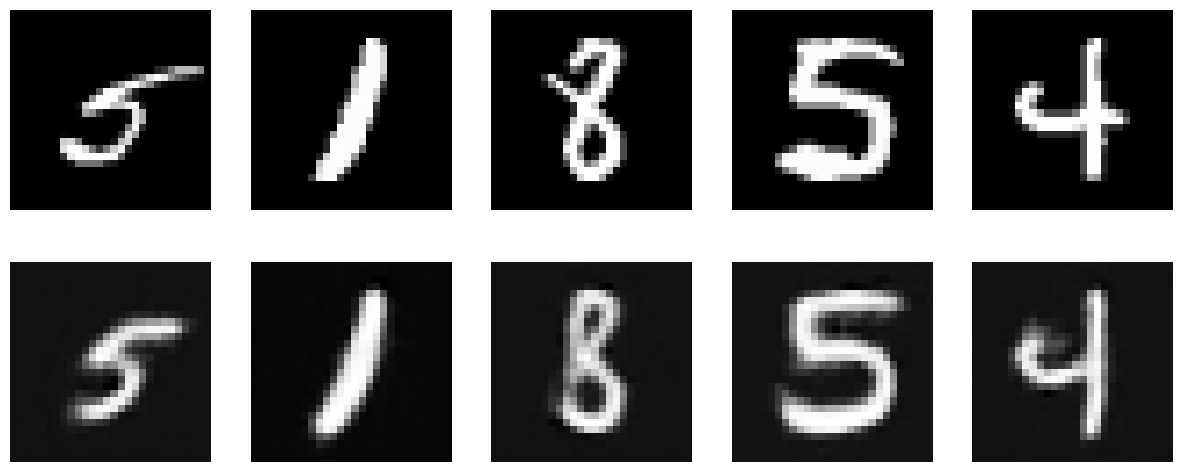


##################################################
VQ-VAE Epoch [46/50], Loss: 0.057453837722285725


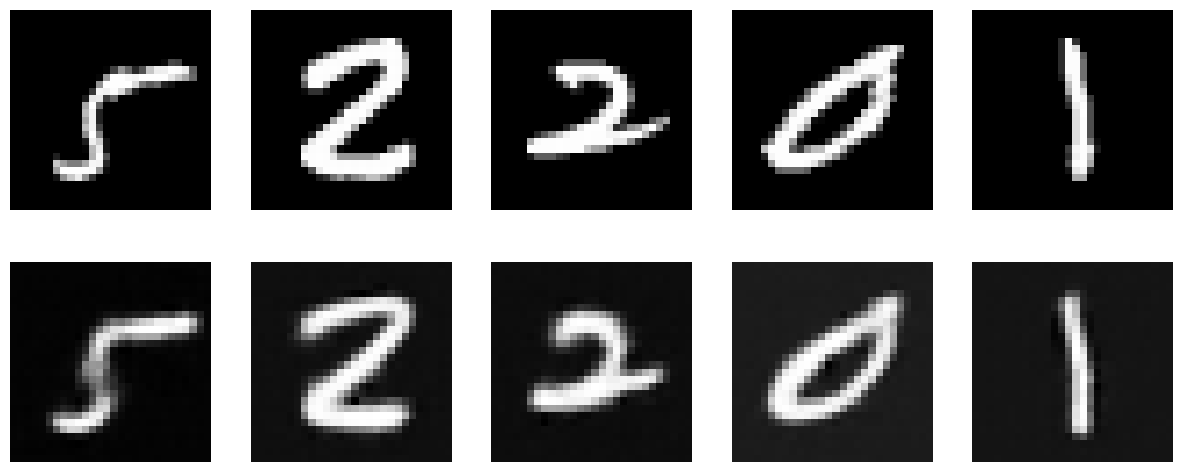


##################################################
VQ-VAE Epoch [47/50], Loss: 0.057574989651439035


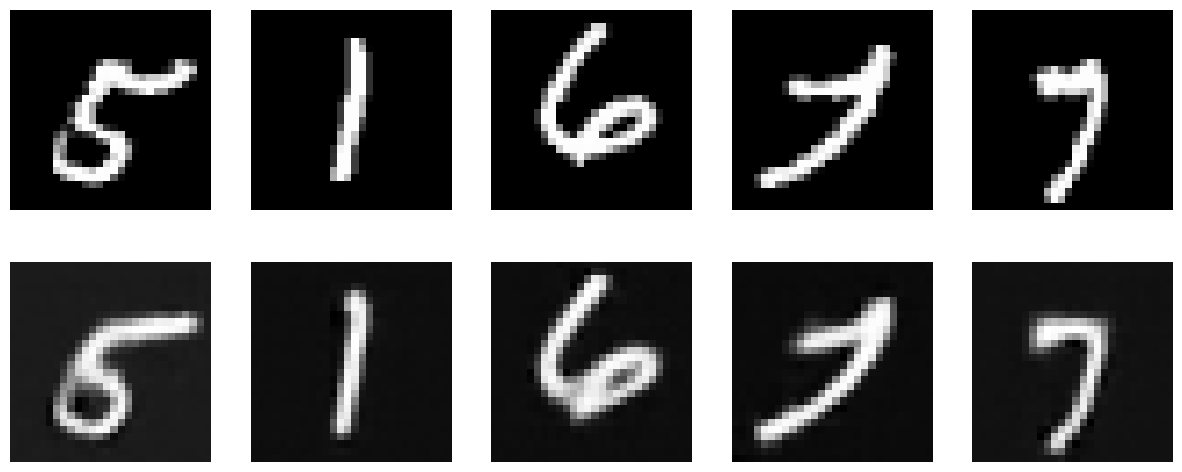


##################################################
VQ-VAE Epoch [48/50], Loss: 0.05751306915095747


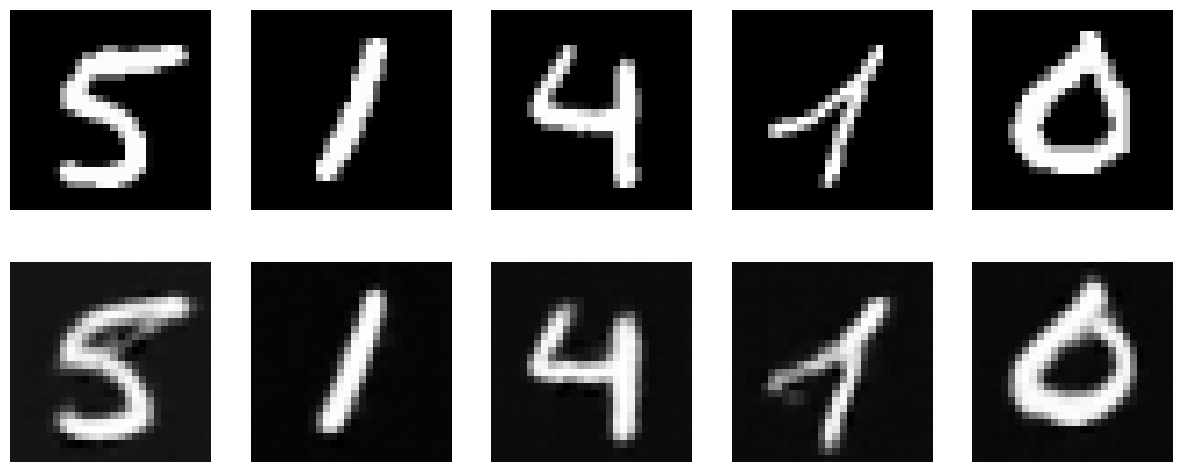


##################################################
VQ-VAE Epoch [49/50], Loss: 0.05744538374388142


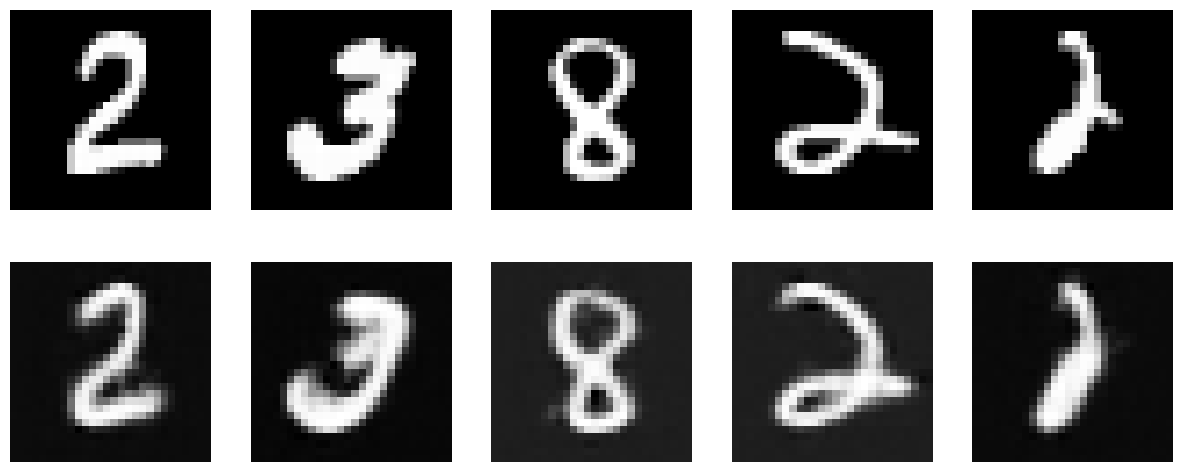


##################################################
VQ-VAE Epoch [50/50], Loss: 0.05763185458746292


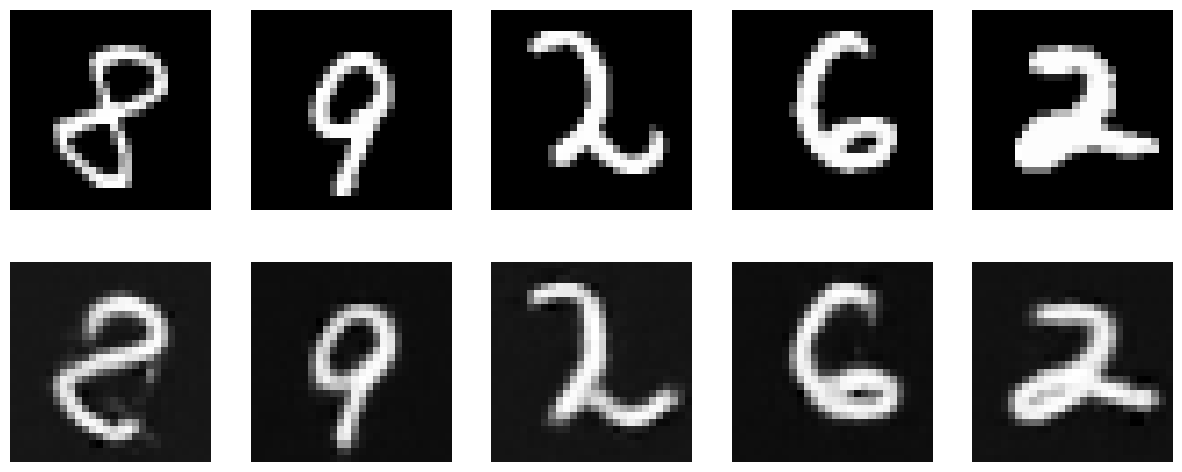

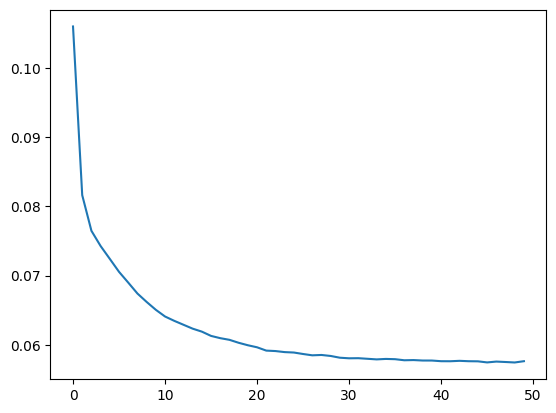

In [31]:
# Training Loop - VAE (MLP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_vq_vae(model, train_loader, num_epochs=50, learning_rate=1e-3):
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None
    images = []
    loss_history = []
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            data = data.to(device)
            output = model(data)

            recon, vq_loss = output[0], output[2]
            loss = F.mse_loss(recon, data) + vq_loss
            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        scheduler.step()

        codebook = output[3]
        vec1, vec2, vec3 = codebook[0, :], codebook[1, :], codebook[2, :]
        plt.quiver(*vec1, angles='xy', scale_units='xy', scale=1, color='r')
        plt.quiver(*vec2, angles='xy', scale_units='xy', scale=1, color='g')
        plt.quiver(*vec3, angles='xy', scale_units='xy', scale=1, color='b')

        plt.xlim(-3, 3)
        plt.ylim(-3, 3)


        plt.savefig(f'frame_{epoch}.png')
        plt.close()

        images.append(imageio.imread(f'frame_{epoch}.png'))
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f'VQ-VAE Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        if epoch % 1 == 0:
            data = data.cpu().numpy()
            recon = recon.detach().cpu().numpy()

            fig, axs = plt.subplots(2, 5, figsize=(15, 6))
            for i in range(5):
                axs[0, i].imshow(data[i].squeeze(), cmap='gray')
                axs[0, i].axis('off')
                axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
                axs[1, i].axis('off')
            plt.show()

    imageio.mimsave('training_vectors.gif', images)
    plt.plot(loss_history)
    plt.show()





vq_vae = VQVAE(in_channels=1, embedding_dim=2, num_embeddings=3)
train_vq_vae(vq_vae, train_loader)

## Effect of number of Embedding vectors

As observed from the following plots, there is a reduction in the loss with an increase in number of embedding vectors.

**********************************************************************
Training Model with 3 embeddings vector

##################################################
VQ-VAE Epoch [1/10], Loss: 0.12441800148295823

##################################################
VQ-VAE Epoch [2/10], Loss: 0.08207833206157948

##################################################
VQ-VAE Epoch [3/10], Loss: 0.08112475372104248

##################################################
VQ-VAE Epoch [4/10], Loss: 0.07553816360355949

##################################################
VQ-VAE Epoch [5/10], Loss: 0.06925966827742962

##################################################
VQ-VAE Epoch [6/10], Loss: 0.06565895385500084

##################################################
VQ-VAE Epoch [7/10], Loss: 0.06361394731411293

##################################################
VQ-VAE Epoch [8/10], Loss: 0.06293411192688733

##################################################
VQ-VAE Epoch [9/10], Loss: 0.0627861690880266

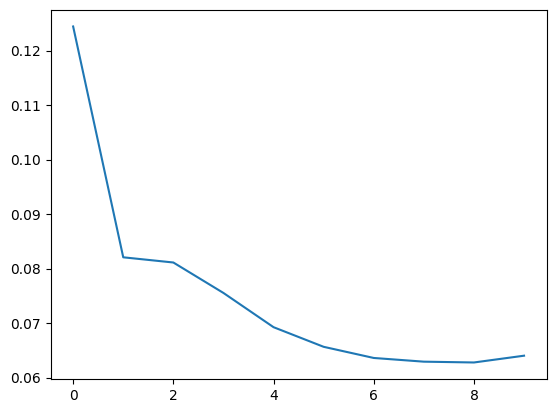

**********************************************************************
Training Model with 13 embeddings vector

##################################################
VQ-VAE Epoch [1/10], Loss: 0.045490726272561656

##################################################
VQ-VAE Epoch [2/10], Loss: 0.022445860690177122

##################################################
VQ-VAE Epoch [3/10], Loss: 0.021213423589796526

##################################################
VQ-VAE Epoch [4/10], Loss: 0.02009771896331613

##################################################
VQ-VAE Epoch [5/10], Loss: 0.019474846680265372

##################################################
VQ-VAE Epoch [6/10], Loss: 0.01885975565491264

##################################################
VQ-VAE Epoch [7/10], Loss: 0.018361261610918715

##################################################
VQ-VAE Epoch [8/10], Loss: 0.017979184757354164

##################################################
VQ-VAE Epoch [9/10], Loss: 0.017699359

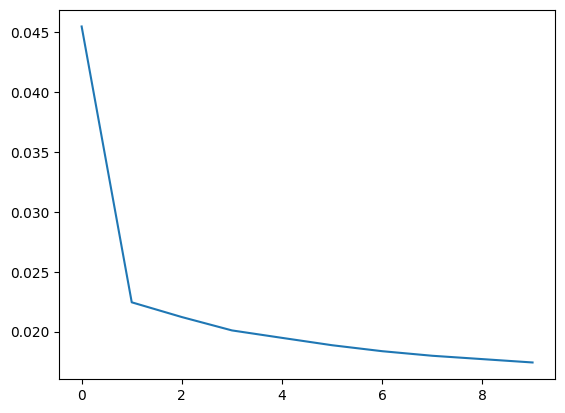

**********************************************************************
Training Model with 23 embeddings vector

##################################################
VQ-VAE Epoch [1/10], Loss: 0.12222235412823397

##################################################
VQ-VAE Epoch [2/10], Loss: 0.01381948386340825

##################################################
VQ-VAE Epoch [3/10], Loss: 0.015031563207459474

##################################################
VQ-VAE Epoch [4/10], Loss: 0.016099958798722988

##################################################
VQ-VAE Epoch [5/10], Loss: 0.0156441297251056

##################################################
VQ-VAE Epoch [6/10], Loss: 0.015137929875435415

##################################################
VQ-VAE Epoch [7/10], Loss: 0.014563367524341161

##################################################
VQ-VAE Epoch [8/10], Loss: 0.014089348867956573

##################################################
VQ-VAE Epoch [9/10], Loss: 0.01369494034

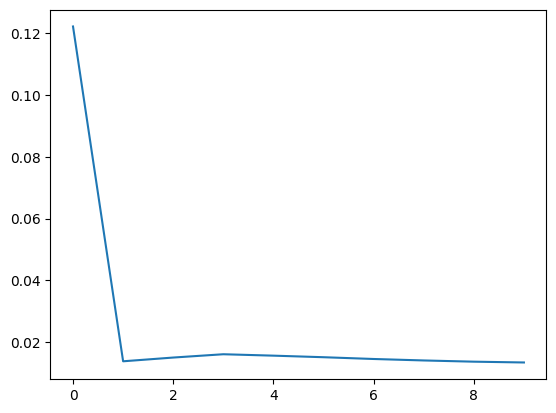

**********************************************************************
Training Model with 33 embeddings vector

##################################################
VQ-VAE Epoch [1/10], Loss: 0.042348398384191334

##################################################
VQ-VAE Epoch [2/10], Loss: 0.01283218151232454

##################################################
VQ-VAE Epoch [3/10], Loss: 0.01290337075350254

##################################################
VQ-VAE Epoch [4/10], Loss: 0.012326749309754447

##################################################
VQ-VAE Epoch [5/10], Loss: 0.011797745686286549

##################################################
VQ-VAE Epoch [6/10], Loss: 0.011313575972268767

##################################################
VQ-VAE Epoch [7/10], Loss: 0.010932692084342305

##################################################
VQ-VAE Epoch [8/10], Loss: 0.010631422741588816

##################################################
VQ-VAE Epoch [9/10], Loss: 0.010390913

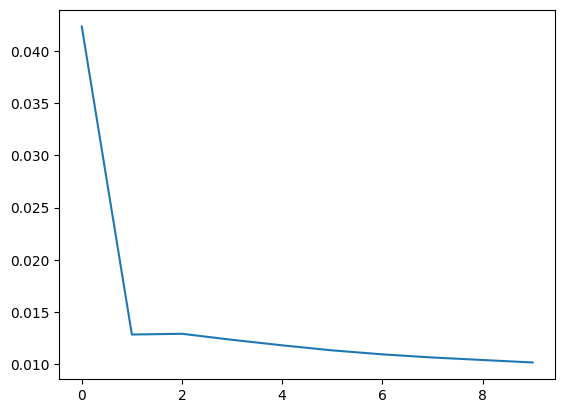

**********************************************************************
Training Model with 43 embeddings vector

##################################################
VQ-VAE Epoch [1/10], Loss: 0.038503038584749134

##################################################
VQ-VAE Epoch [2/10], Loss: 0.010929298445161408

##################################################
VQ-VAE Epoch [3/10], Loss: 0.010752039530606413

##################################################
VQ-VAE Epoch [4/10], Loss: 0.010477614643643978

##################################################
VQ-VAE Epoch [5/10], Loss: 0.010138018712051895

##################################################
VQ-VAE Epoch [6/10], Loss: 0.009849717862395716

##################################################
VQ-VAE Epoch [7/10], Loss: 0.009579550893877997

##################################################
VQ-VAE Epoch [8/10], Loss: 0.009364854661561152

##################################################
VQ-VAE Epoch [9/10], Loss: 0.0091845

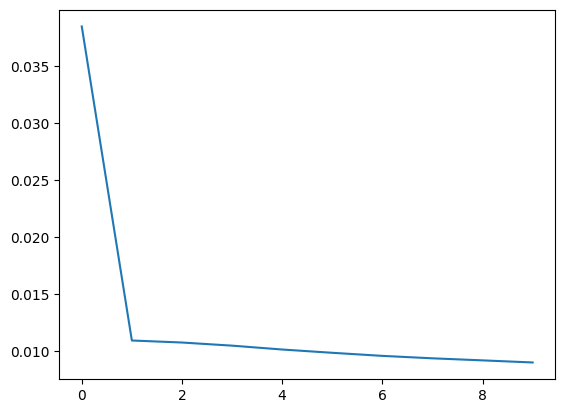

**********************************************************************
Training Model with 53 embeddings vector

##################################################
VQ-VAE Epoch [1/10], Loss: 0.060728108727816005

##################################################
VQ-VAE Epoch [2/10], Loss: 0.010157202481667496

##################################################
VQ-VAE Epoch [3/10], Loss: 0.010115972056841926

##################################################
VQ-VAE Epoch [4/10], Loss: 0.010006019047328405

##################################################
VQ-VAE Epoch [5/10], Loss: 0.009693148912294015

##################################################
VQ-VAE Epoch [6/10], Loss: 0.009448998459755803

##################################################
VQ-VAE Epoch [7/10], Loss: 0.00914305977588857

##################################################
VQ-VAE Epoch [8/10], Loss: 0.008849907756796968

##################################################
VQ-VAE Epoch [9/10], Loss: 0.00845787

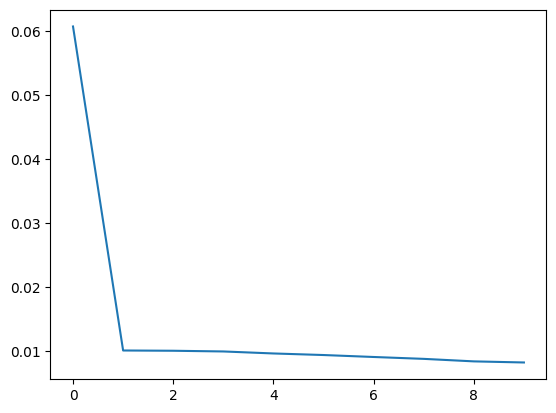

In [26]:
import torch
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset

class ColorMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, seed=123):
        self.mnist_data = datasets.MNIST(root=root, train=train, download=download, transform=transforms.ToTensor())
        self.transform = transform
        self.target_transform = target_transform
        self.seed = seed

    def __getitem__(self, index):
        image, label = self.mnist_data[index]

        np.random.seed(self.seed + index)

        r, g, b = np.random.rand(3)
        rgb_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.float32)
        rgb_image[:, :, 0] = image * r
        rgb_image[:, :, 1] = image * g
        rgb_image[:, :, 2] = image * b

        if self.transform is not None:
            rgb_image = self.transform(rgb_image)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return rgb_image, label

    def __len__(self):
        return len(self.mnist_data)




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_vq_vae1(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    best_loss = float('inf')
    best_model = None
    images = []
    loss_history = []
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            data = data.to(device)
            output = model(data)

            recon, vq_loss = output[0], output[2]
            loss = F.mse_loss(recon, data) + vq_loss
            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        scheduler.step()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f'VQ-VAE Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

    plt.plot(loss_history)
    plt.show()






transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for num_embed in range(3, 54, 10):
    print(70*'*')
    print(f'Training Model with {num_embed} embeddings vector')
    vq_vae = VQVAE(in_channels=1, embedding_dim=2, num_embeddings=num_embed)
    train_vq_vae1(vq_vae, train_loader)

## Effect of Dimensionality

As observed from the plots, there is no reduction in the loss despite an increase in dimensionality.

**********************************************************************
Training Model with embedding vectors of dimension 2

##################################################
VQ-VAE Epoch [1/10], Loss: 0.08386787464385474

##################################################
VQ-VAE Epoch [2/10], Loss: 0.0784421086565518

##################################################
VQ-VAE Epoch [3/10], Loss: 0.07261846500879793

##################################################
VQ-VAE Epoch [4/10], Loss: 0.06934448837566731

##################################################
VQ-VAE Epoch [5/10], Loss: 0.06829160966995809

##################################################
VQ-VAE Epoch [6/10], Loss: 0.0680826352611343

##################################################
VQ-VAE Epoch [7/10], Loss: 0.06835941527126187

##################################################
VQ-VAE Epoch [8/10], Loss: 0.07134973716888346

##################################################
VQ-VAE Epoch [9/10], Loss: 0.06533

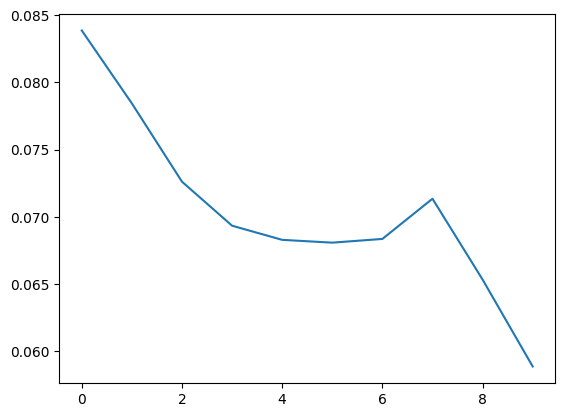

**********************************************************************
Training Model with embedding vectors of dimension 12

##################################################
VQ-VAE Epoch [1/10], Loss: 0.20709569824498092

##################################################
VQ-VAE Epoch [2/10], Loss: 0.1136912758162281

##################################################
VQ-VAE Epoch [3/10], Loss: 0.08875827517495481

##################################################
VQ-VAE Epoch [4/10], Loss: 0.07993937425934938

##################################################
VQ-VAE Epoch [5/10], Loss: 0.07450584323405585

##################################################
VQ-VAE Epoch [6/10], Loss: 0.0697022533612147

##################################################
VQ-VAE Epoch [7/10], Loss: 0.06743812414883042

##################################################
VQ-VAE Epoch [8/10], Loss: 0.06597741185697412

##################################################
VQ-VAE Epoch [9/10], Loss: 0.0647

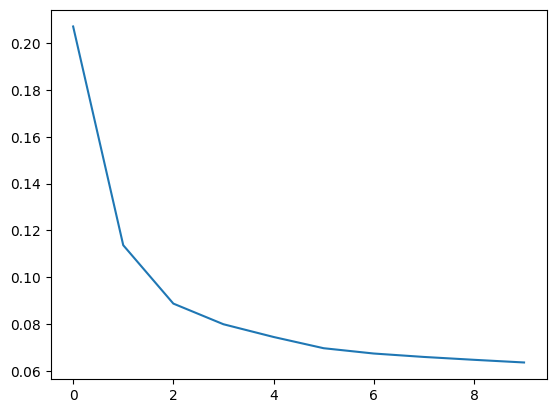

**********************************************************************
Training Model with embedding vectors of dimension 22

##################################################
VQ-VAE Epoch [1/10], Loss: 0.1783465158297563

##################################################
VQ-VAE Epoch [2/10], Loss: 0.1058032485499565

##################################################
VQ-VAE Epoch [3/10], Loss: 0.09147850827558208

##################################################
VQ-VAE Epoch [4/10], Loss: 0.08360811217284914

##################################################
VQ-VAE Epoch [5/10], Loss: 0.07834006596539321

##################################################
VQ-VAE Epoch [6/10], Loss: 0.07542004066902691

##################################################
VQ-VAE Epoch [7/10], Loss: 0.0730273500720321

##################################################
VQ-VAE Epoch [8/10], Loss: 0.07123624311803754

##################################################
VQ-VAE Epoch [9/10], Loss: 0.06958

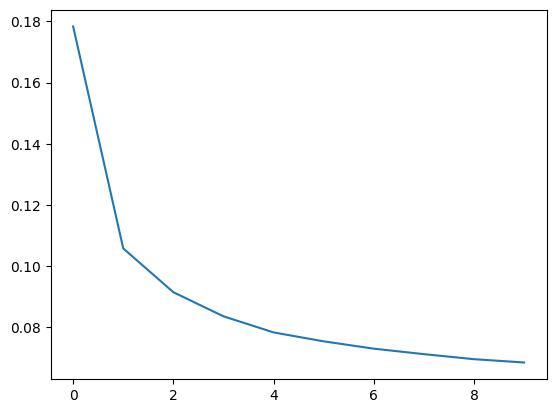

**********************************************************************
Training Model with embedding vectors of dimension 32

##################################################
VQ-VAE Epoch [1/10], Loss: 0.19075511824855926

##################################################
VQ-VAE Epoch [2/10], Loss: 0.12156826914595897

##################################################
VQ-VAE Epoch [3/10], Loss: 0.09903173627597946

##################################################
VQ-VAE Epoch [4/10], Loss: 0.08631116909576632

##################################################
VQ-VAE Epoch [5/10], Loss: 0.07961007412562747

##################################################
VQ-VAE Epoch [6/10], Loss: 0.07511387196685206

##################################################
VQ-VAE Epoch [7/10], Loss: 0.07203438116718075

##################################################
VQ-VAE Epoch [8/10], Loss: 0.07044443665648192

##################################################
VQ-VAE Epoch [9/10], Loss: 0.06

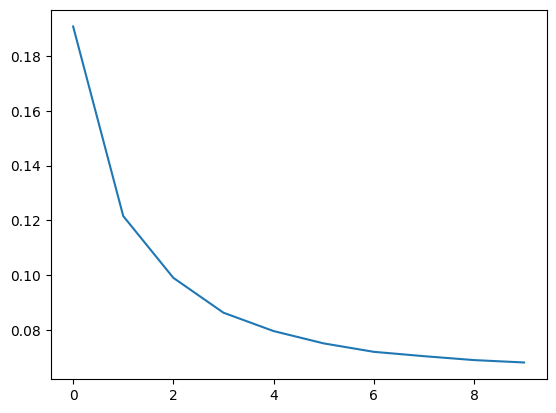

**********************************************************************
Training Model with embedding vectors of dimension 42

##################################################
VQ-VAE Epoch [1/10], Loss: 0.20410703674657768

##################################################
VQ-VAE Epoch [2/10], Loss: 0.1331321653812679

##################################################
VQ-VAE Epoch [3/10], Loss: 0.11336760205437126

##################################################
VQ-VAE Epoch [4/10], Loss: 0.09497427653624559

##################################################
VQ-VAE Epoch [5/10], Loss: 0.08350104281007609

##################################################
VQ-VAE Epoch [6/10], Loss: 0.07660521735260481

##################################################
VQ-VAE Epoch [7/10], Loss: 0.0723830491526803

##################################################
VQ-VAE Epoch [8/10], Loss: 0.0689888898886915

##################################################
VQ-VAE Epoch [9/10], Loss: 0.06672

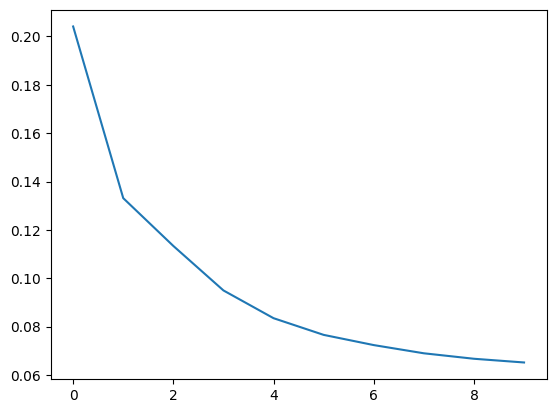

**********************************************************************
Training Model with embedding vectors of dimension 52

##################################################
VQ-VAE Epoch [1/10], Loss: 0.1911035990282925

##################################################
VQ-VAE Epoch [2/10], Loss: 0.07835318762928184

##################################################
VQ-VAE Epoch [3/10], Loss: 0.06285978466081721

##################################################
VQ-VAE Epoch [4/10], Loss: 0.058519674107623

##################################################
VQ-VAE Epoch [5/10], Loss: 0.05696913956610887

##################################################
VQ-VAE Epoch [6/10], Loss: 0.0558202388340921

##################################################
VQ-VAE Epoch [7/10], Loss: 0.05488738535182563

##################################################
VQ-VAE Epoch [8/10], Loss: 0.05384437078590205

##################################################
VQ-VAE Epoch [9/10], Loss: 0.052878

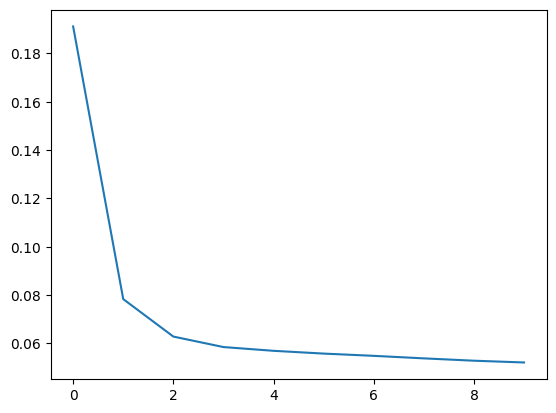

In [28]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for dim_embed in range(2, 54, 10):
    print(70*'*')
    print(f'Training Model with embedding vectors of dimension {dim_embed}')
    vq_vae = VQVAE(in_channels=1, embedding_dim=dim_embed, num_embeddings=3)
    train_vq_vae1(vq_vae, train_loader)